In [2]:
from sql_connector import mydb, mycursor
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from igraph import Graph
import igraph as ig
import networkx
import mysql as mysql

import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import random

from imblearn.under_sampling import RandomUnderSampler
from catboost import CatBoostClassifier
from sklearn.datasets import make_classification
from collections import Counter

# Set seed for reproducibility
np.random.seed(42)
random.seed(42)



In [3]:
##########################################################################################################################################
###                                                 Users Classification
###                 Catboost model to predict if a user will become an author of a new tweet, after he had retweeted       
###
##########################################################################################################################################

In [4]:
## UNDERSAMPLING
X_u = pd.read_parquet('X_u_tm_1.parquet')
y_u = pd.read_parquet('y_u_tm_1.parquet')['label']

undersample = RandomUnderSampler(sampling_strategy='majority')

# Split to train, test
X_train_u, X_test_u, y_train_u, y_test_u = train_test_split(X_u, y_u, test_size=0.2, random_state=42, stratify=y_u)
# Split to train, val
X_train_u, X_val_u, y_train_u, y_val_u = train_test_split(X_train_u, y_train_u, test_size=0.2, random_state=42, stratify=y_train_u)
# Undersample train
X_train_us_u, y_train_us_u = undersample.fit_resample(X_train_u, y_train_u)
X_val_us_u, y_val_us_u = undersample.fit_resample(X_val_u, y_val_u)
X_test_us_u, y_test_us_u = undersample.fit_resample(X_test_u, y_test_u)

# Count occurrences in each dataset
train_counts = y_train_us_u.value_counts()
val_counts = y_val_us_u.value_counts()
test_counts = y_test_us_u.value_counts()
test_counts_imbalanced = y_test_u.value_counts()

print("Train set class counts:\n", train_counts, "\n")
print("Validation set class counts:\n", val_counts, "\n")
print("Test set class counts:\n", test_counts, "\n")
print("imbalanced test set class counts:\n", test_counts_imbalanced, "\n")


Train set class counts:
 label
0    10171
1    10171
Name: count, dtype: int64 

Validation set class counts:
 label
0    2543
1    2543
Name: count, dtype: int64 

Test set class counts:
 label
0    3178
1    3178
Name: count, dtype: int64 

imbalanced test set class counts:
 label
0    46498
1     3178
Name: count, dtype: int64 



In [10]:
def save_catboost_evaluation_results(model_file_path, X_test, y_test, X_test_b, y_test_b, output_file_path):
    # Load the saved model
    model_cat_u_best_loaded = CatBoostClassifier(random_state=42)
    model_cat_u_best_loaded.load_model(model_file_path)

    # Define feature names (ensure X_test has the columns defined)
    feature_names = X_test.columns

    # Retrieve and sort feature importance
    feature_importance = model_cat_u_best_loaded.get_feature_importance()
    feature_importance_map = dict(zip(feature_names, feature_importance))
    sorted_importance = sorted(feature_importance_map.items(), key=lambda x: x[1], reverse=True)

    # Predict with the loaded model
    y_pred = model_cat_u_best_loaded.predict(X_test)
    y_pred_b = model_cat_u_best_loaded.predict(X_test_b)

    # Compute the classification report
    report = classification_report(y_test, y_pred, digits=4)
    report_b = classification_report(y_test_b, y_pred_b, digits=4)

    # Write results to the file
    with open(output_file_path, 'w') as f:
        # Get hyperparameters
        params = model_cat_u_best_loaded.get_params()
        f.write("\nHyperparameters:\n")
        for key, value in params.items():
            f.write(f"{key}: {value}\n")
    
        # Write classification report
        f.write("\nClassification Report:\n")
        f.write(f"{report}\n")
        
        f.write("\nClassification Report:\n")
        f.write(f"{report_b}\n")
    
        # Write feature importance
        f.write("Feature Importance from the Loaded Model:\n")
        for feature_name, importance in sorted_importance:
            f.write(f"{feature_name}: {importance}\n")


def save_lgbm_evaluation_results(model_file_path, X_test, y_test, X_test_b, y_test_b, output_file_path):
    # Load the saved model
    model_lgb_loaded = joblib.load(model_file_path)

    # Define feature names (ensure X_test has the columns defined)
    feature_names = X_test.columns

    # Retrieve and sort feature importance
    feature_importance = model_lgb_loaded.feature_importances_
    feature_importance_map = dict(zip(feature_names, feature_importance))
    sorted_importance = sorted(feature_importance_map.items(), key=lambda x: x[1], reverse=True)

    print("Top 20 Feature Importance:")
    for feature_name, importance in sorted_importance:
        print(f"{feature_name}: {importance}")

    # Predict with the loaded model
    y_pred = model_lgb_loaded.predict(X_test)
    y_pred = (y_pred > 0.5).astype(int)  
    
    y_pred_b = model_lgb_loaded.predict(X_test_b)
    y_pred_b = (y_pred_b > 0.5).astype(int)  

    # Compute the classification report
    report = classification_report(y_test, y_pred, digits=4)
    report_b = classification_report(y_test_b, y_pred_b, digits=4)

    # Write results to the file
    with open(output_file_path, 'w') as f:
        # Get hyperparameters
        params = model_lgb_loaded.get_params()
        f.write("Hyperparameters:\n")
        for key, value in params.items():
            f.write(f"{key}: {value}\n")
    
        # Write classification report
        f.write("\nClassification Report:\n")
        f.write(f"{report}\n")
        f.write("\nClassification Report:\n")
        f.write(f"{report_b}\n")
        
        # Write feature importance
        f.write("Feature Importance from the Loaded Model:\n")
        for feature_name, importance in sorted_importance:
            f.write(f"{feature_name}: {importance}\n")
            
        
def save_nn_evaluation_results(model_file_path, X_test, y_test, X_test_b, y_test_b, output_file_path):
    # Load the saved model
    model_nn_best_loaded = joblib.load(model_file_path)

    # Define feature names (ensure X_test has the columns defined)
    feature_names = X_test.columns

    # Predict with the loaded model
    y_pred = model_nn_best_loaded.predict(X_test)
    y_pred_b = model_nn_best_loaded.predict(X_test_b)

    # Compute the classification report
    report = classification_report(y_test, y_pred, digits=4)
    report_b = classification_report(y_test_b, y_pred_b, digits=4)
    


    # Write results to the file
    with open(output_file_path, 'w') as f:
        # Get hyperparameters
        params = model_nn_best_loaded.named_steps['mlpclassifier'].get_params()
        f.write("Hyperparameters:\n")
        for key, value in params.items():
            f.write(f"{key}: {value}\n")
    
        # Write classification report
        f.write("\nClassification Report:\n")
        f.write(f"{report}\n")
        f.write("\nClassification Report:\n")
        f.write(f"{report_b}\n")
        
        # Note: MLPClassifier does not provide feature importance directly
        f.write("Feature Importance is not available for MLPClassifier.\n")
        
        
def save_xgb_evaluation_results(model_file_path, X_test, y_test, X_test_b, y_test_b, output_file_path):
    import joblib
    from sklearn.metrics import classification_report
    
    # Load the saved model
    model_xgb_loaded = joblib.load(model_file_path)

    # Define feature names (ensure X_test has the columns defined)
    feature_names = X_test.columns

    # Retrieve and sort feature importance
    feature_importance = model_xgb_loaded.feature_importances_
    feature_importance_map = dict(zip(feature_names, feature_importance))
    sorted_importance = sorted(feature_importance_map.items(), key=lambda x: x[1], reverse=True)

    print("Top 20 Feature Importance:")
    for feature_name, importance in sorted_importance[:20]:  # Print only the top 20
        print(f"{feature_name}: {importance}")

    # Predict with the loaded model
    y_pred = model_xgb_loaded.predict(X_test)
    y_pred = (y_pred > 0.5).astype(int)  # Threshold for binary classification
    
    y_pred_b = model_xgb_loaded.predict(X_test_b)
    y_pred_b = (y_pred_b > 0.5).astype(int)  # Threshold for binary classification

    # Compute the classification report
    report = classification_report(y_test, y_pred, digits=4)
    report_b = classification_report(y_test_b, y_pred_b, digits=4)

    # Write results to the file
    with open(output_file_path, 'w') as f:
        # Get hyperparameters
        params = model_xgb_loaded.get_params()
        f.write("Hyperparameters:\n")
        for key, value in params.items():
            f.write(f"{key}: {value}\n")
    
        # Write classification reports
        f.write("\nClassification Report:\n")
        f.write(f"{report}\n")
        f.write("\nClassification Report:\n")
        f.write(f"{report_b}\n")
        
        # Write feature importance
        f.write("\nFeature Importance from the Loaded Model:\n")
        for feature_name, importance in sorted_importance[:20]:  # Write only the top 20
            f.write(f"{feature_name}: {importance}\n")


In [13]:
# Model CATBOOST
import optuna
from catboost import CatBoostClassifier
from sklearn.metrics import accuracy_score, f1_score, classification_report
from tqdm import tqdm

# Define the objective function for Optuna
def objective(trial):
    # Suggest hyperparameters
    params = {
        "depth": trial.suggest_int("depth", 4, 12),  # Depth of the trees
        "learning_rate": trial.suggest_float("learning_rate", 0.001, 0.3, log=True),  # Learning rate
        "l2_leaf_reg": trial.suggest_float("l2_leaf_reg", 1e-5, 10, log=True),  # L2 regularization term
        "min_data_in_leaf": trial.suggest_int("min_data_in_leaf", 10, 50),  # Minimum number of data points in a leaf
        "max_bin": trial.suggest_int("max_bin", 128, 256),
        "grow_policy": trial.suggest_categorical("grow_policy", ["SymmetricTree", "Depthwise", "Lossguide"]),  # Tree growing policy
        "iterations": trial.suggest_int("iterations", 100, 1000),  # Number of boosting iterations (trees)
    }
    # Initialize and train the model
    # model = CatBoostClassifier(**params, random_seed=42, task_type="GPU", verbose=1)
    model = CatBoostClassifier(
    **params, 
    random_seed=42, 
    # task_type="GPU", 
    # devices='0',
    verbose=1
)
    model.fit(X_train_us_u, y_train_us_u, eval_set=(X_val_us_u, y_val_us_u), early_stopping_rounds=50)

    # Predict and evaluate
    y_pred = model.predict(X_test_u)
    f1_macro = f1_score(y_test_u, y_pred, average='macro')

    return f1_macro

# Define the number of trials
n_trials = 50

# Run the optimization with a progress bar
study = optuna.create_study(direction='maximize', sampler=optuna.samplers.TPESampler(seed=42))
study.optimize(objective, n_trials=n_trials, show_progress_bar=True)

# Retrieve the best parameters
best_params = study.best_params
print(f"Best parameters found by Optuna: {best_params}")

# Train final model with the best parameters
# model_cat_u_best = CatBoostClassifier(**best_params, task_type="GPU", verbose=0)
model_cat_u_best = CatBoostClassifier(
    **best_params, 
    random_seed=42, 
    # task_type="GPU", 
    # devices='0',
    verbose=0
)
model_cat_u_best.fit(X_train_us_u, y_train_us_u)

# Predict and evaluate with the best model
y_pred_cat_u_best = model_cat_u_best.predict(X_test_u)

# Print metrics
print(f'Accuracy: {accuracy_score(y_test_u, y_pred_cat_u_best):.4f}')
print("Classification Report:")
print(classification_report(y_test_u, y_pred_cat_u_best, digits=4))
# Define feature names
feature_names_u = X_train_us_u.columns
# Feature importance
feature_importance_cat_u_best = model_cat_u_best.get_feature_importance()
feature_importance_map_u_best = dict(zip(feature_names_u, feature_importance_cat_u_best))
sorted_importance_cat_u_best = sorted(feature_importance_map_u_best.items(), key=lambda x: x[1], reverse=True)[:20]

print("Top 20 Feature Importance:")
for feature_name, importance in sorted_importance_cat_u_best:
    print(f"{feature_name}: {importance}")
    
model_cat_u_best.save_model('models/catboost_u_tm_3.cbm')
save_catboost_evaluation_results('models/catboost_u_tm_3.cbm', X_test_u, y_test_u, X_test_us_u, y_test_us_u, 'models/catboost_u_tm_3.txt')


[I 2024-09-08 12:08:15,135] A new study created in memory with name: no-name-ba8ce54c-341e-49bb-8ff1-e2be2842d487


  0%|          | 0/50 [00:00<?, ?it/s]

0:	learn: 0.6516809	test: 0.6534233	best: 0.6534233 (0)	total: 40.2ms	remaining: 25.7s
1:	learn: 0.6271234	test: 0.6315545	best: 0.6315545 (1)	total: 77.3ms	remaining: 24.7s
2:	learn: 0.6093147	test: 0.6157256	best: 0.6157256 (2)	total: 116ms	remaining: 24.6s
3:	learn: 0.5976444	test: 0.6068593	best: 0.6068593 (3)	total: 154ms	remaining: 24.5s
4:	learn: 0.5889394	test: 0.6001442	best: 0.6001442 (4)	total: 193ms	remaining: 24.6s
5:	learn: 0.5818235	test: 0.5953224	best: 0.5953224 (5)	total: 231ms	remaining: 24.5s
6:	learn: 0.5745499	test: 0.5895215	best: 0.5895215 (6)	total: 273ms	remaining: 24.7s
7:	learn: 0.5691992	test: 0.5860480	best: 0.5860480 (7)	total: 315ms	remaining: 24.9s
8:	learn: 0.5649892	test: 0.5837897	best: 0.5837897 (8)	total: 356ms	remaining: 25s
9:	learn: 0.5618603	test: 0.5817133	best: 0.5817133 (9)	total: 397ms	remaining: 25.1s
10:	learn: 0.5579438	test: 0.5800097	best: 0.5800097 (10)	total: 606ms	remaining: 34.7s
11:	learn: 0.5544209	test: 0.5780572	best: 0.5780572

In [11]:
from catboost import CatBoostClassifier
save_catboost_evaluation_results('models/catboost_u3.cbm', X_test_u, y_test_u, X_test_us_u, y_test_us_u, 'models/catboost_u3.txt')


In [4]:
#LGBM
import os
import optuna
from sklearn.metrics import accuracy_score, f1_score, classification_report
from tqdm import tqdm

# Set the number of CPU cores to use
os.environ['LOKY_MAX_CPU_COUNT'] = '4'
# Define the objective function for Optuna
def objective(trial):
    # Suggest hyperparameters
    params = {
        "objective": "binary",
        "metric": "binary_error",
        "num_leaves": trial.suggest_int("num_leaves", 31, 255),
        "learning_rate": trial.suggest_float("learning_rate", 0.001, 0.3, log=True),
        "feature_fraction": trial.suggest_float("feature_fraction", 0.1, 1.0),
        "bagging_fraction": trial.suggest_float("bagging_fraction", 0.1, 1.0),
        "bagging_freq": trial.suggest_int("bagging_freq", 1, 10),
        "lambda_l1": trial.suggest_float("lambda_l1", 0.0, 10.0),
        "lambda_l2": trial.suggest_float("lambda_l2", 0.0, 10.0),
        "min_child_samples": trial.suggest_int("min_child_samples", 1, 100),
        "max_depth": trial.suggest_int("max_depth", -1, 50),  # -1 means no limit
        "min_child_weight": trial.suggest_float("min_child_weight", 0.0, 10.0),
        "scale_pos_weight": trial.suggest_float("scale_pos_weight", 1.0, 10.0),
        "subsample_for_bin": trial.suggest_int("subsample_for_bin", 200000, 300000),
        "cat_smooth": trial.suggest_float("cat_smooth", 1.0, 20.0),
        "num_boost_round": trial.suggest_int("num_boost_round", 100, 1000),
        "num_threads": -1
    }
    
    # Initialize and train the model
    model = lgb.LGBMClassifier(**params)
    model.fit(X_train_us_u, y_train_us_u,
              eval_set=[(X_val_us_u, y_val_us_u)],
              eval_metric='binary_error')

    # Predict and evaluate
    y_pred = model.predict(X_test_u)
    f1_macro = f1_score(y_test_u, y_pred, average='macro')
    
    return f1_macro

# Define the number of trials
n_trials = 50

# Run the optimization with a progress bar
study = optuna.create_study(direction='maximize', sampler=optuna.samplers.TPESampler())
study.optimize(objective, n_trials=n_trials, show_progress_bar=True)

# Retrieve the best parameters
best_params = study.best_params
print(f"Best parameters found by Optuna: {best_params}")

# Train final model with the best parameters
model_lgb_best = lgb.LGBMClassifier(**best_params)
model_lgb_best.fit(X_train_us_u, y_train_us_u)

# Predict and evaluate with the best model
y_pred_lgb_best = model_lgb_best.predict(X_test_u)

# Print metrics
print(f'Accuracy: {accuracy_score(y_test_u, y_pred_lgb_best):.4f}')
print("Classification Report:")
print(classification_report(y_test_u, y_pred_lgb_best, digits=4))

# Define feature names
feature_names_u = X_train_us_u.columns
# Feature importance
feature_importance_lgb_best = model_lgb_best.feature_importances_
feature_importance_map_lgb_best = dict(zip(feature_names_u, feature_importance_lgb_best))
sorted_importance_lgb_best = sorted(feature_importance_map_lgb_best.items(), key=lambda x: x[1], reverse=True)[:20]

print("Top 20 Feature Importance:")
for feature_name, importance in sorted_importance_lgb_best:
    print(f"{feature_name}: {importance}")

# Save the model
import joblib

joblib.dump(model_lgb_best, 'models/lightgbm_u_tm_2.joblib')
save_lgbm_evaluation_results('models/lightgbm_u_tm_2.joblib', X_test_u, y_test_u, X_test_us_u, y_test_us_u, 'models/lightgbm_u_tm_2.txt')


[I 2024-09-01 11:40:40,541] A new study created in memory with name: no-name-0f062cf5-c6bc-48dc-9d74-3f732d2df044


  0%|          | 0/50 [00:00<?, ?it/s]

C:\Users\pelegel\PycharmProjects\pythonProject1\myenv\Lib\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] feature_fraction is set=0.7265131777841468, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7265131777841468
[LightGBM] [Warning] lambda_l1 is set=8.47251626751997, reg_alpha=0.0 will be ignored. Current value: lambda_l1=8.47251626751997
[LightGBM] [Warning] lambda_l2 is set=5.806378200389358, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.806378200389358
[LightGBM] [Warning] bagging_fraction is set=0.7805506124673502, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7805506124673502
[LightGBM] [Warning] bagging_freq is set=9, subsample_freq=0 will be ignored. Current value: bagging_freq=9
[LightGBM] [Warning] num_iterations is set=148, num_boost_round=148 will be ignored. Current value: num_iterations=148
[LightGBM] [Warning] feature_fraction is set=0.7265131777841468, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7265131777841468
[LightGBM] [Warning] lambda_l1 is set=8.47251626751997, r

C:\Users\pelegel\PycharmProjects\pythonProject1\myenv\Lib\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] feature_fraction is set=0.22789337885217006, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.22789337885217006
[LightGBM] [Warning] lambda_l1 is set=9.9227148763006, reg_alpha=0.0 will be ignored. Current value: lambda_l1=9.9227148763006
[LightGBM] [Warning] lambda_l2 is set=0.555517219482895, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.555517219482895
[LightGBM] [Warning] bagging_fraction is set=0.30235063909088145, subsample=1.0 will be ignored. Current value: bagging_fraction=0.30235063909088145
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Info] Number of positive: 10171, number of negative: 10171
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.025190 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 31395
[LightGBM] [Info] Number of data points in the train set: 20

C:\Users\pelegel\PycharmProjects\pythonProject1\myenv\Lib\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] feature_fraction is set=0.2403213922256179, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2403213922256179
[LightGBM] [Warning] lambda_l1 is set=9.9567881744804, reg_alpha=0.0 will be ignored. Current value: lambda_l1=9.9567881744804
[LightGBM] [Warning] lambda_l2 is set=4.5276723954687945, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.5276723954687945
[LightGBM] [Warning] bagging_fraction is set=0.7314524857616932, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7314524857616932
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Info] Number of positive: 10171, number of negative: 10171
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.038867 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 31395
[LightGBM] [Info] Number of data points in the train set: 2034

C:\Users\pelegel\PycharmProjects\pythonProject1\myenv\Lib\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] feature_fraction is set=0.5201124412305441, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5201124412305441
[LightGBM] [Warning] lambda_l1 is set=3.7282082786365156, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.7282082786365156
[LightGBM] [Warning] lambda_l2 is set=4.873762383135809, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.873762383135809
[LightGBM] [Warning] bagging_fraction is set=0.3763176685845404, subsample=1.0 will be ignored. Current value: bagging_fraction=0.3763176685845404
[LightGBM] [Warning] bagging_freq is set=9, subsample_freq=0 will be ignored. Current value: bagging_freq=9
[LightGBM] [Info] Number of positive: 10171, number of negative: 10171
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.044291 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 31385
[LightGBM] [Info] Number of data points in the train set: 

C:\Users\pelegel\PycharmProjects\pythonProject1\myenv\Lib\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] feature_fraction is set=0.13292232949641053, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.13292232949641053
[LightGBM] [Warning] lambda_l1 is set=2.0860050846590816, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.0860050846590816
[LightGBM] [Warning] lambda_l2 is set=7.952677873928657, reg_lambda=0.0 will be ignored. Current value: lambda_l2=7.952677873928657
[LightGBM] [Warning] bagging_fraction is set=0.4221885489942234, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4221885489942234
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Info] Number of positive: 10171, number of negative: 10171
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007720 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bin

C:\Users\pelegel\PycharmProjects\pythonProject1\myenv\Lib\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] feature_fraction is set=0.8854247607049835, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8854247607049835
[LightGBM] [Warning] lambda_l1 is set=0.7361913558696476, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.7361913558696476
[LightGBM] [Warning] lambda_l2 is set=2.968844713040623, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.968844713040623
[LightGBM] [Warning] bagging_fraction is set=0.27091861167166875, subsample=1.0 will be ignored. Current value: bagging_fraction=0.27091861167166875
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Info] Number of positive: 10171, number of negative: 10171
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.030202 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 31395
[LightGBM] [Info] Number of data points in the train set

C:\Users\pelegel\PycharmProjects\pythonProject1\myenv\Lib\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] feature_fraction is set=0.5958969166489531, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5958969166489531
[LightGBM] [Warning] lambda_l1 is set=2.5160010775260613, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.5160010775260613
[LightGBM] [Warning] lambda_l2 is set=6.804086184256963, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.804086184256963
[LightGBM] [Warning] bagging_fraction is set=0.8643746044236371, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8643746044236371
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Info] Number of positive: 10171, number of negative: 10171
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.036416 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 31395
[LightGBM] [Info] Number of data points in the train set: 

C:\Users\pelegel\PycharmProjects\pythonProject1\myenv\Lib\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] feature_fraction is set=0.8751480076671724, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8751480076671724
[LightGBM] [Warning] lambda_l1 is set=6.20045795794463, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.20045795794463
[LightGBM] [Warning] lambda_l2 is set=7.754251734895639, reg_lambda=0.0 will be ignored. Current value: lambda_l2=7.754251734895639
[LightGBM] [Warning] bagging_fraction is set=0.8945121235741721, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8945121235741721
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Info] Number of positive: 10171, number of negative: 10171
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.032130 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 31395
[LightGBM] [Info] Number of data points in the train set: 2034

C:\Users\pelegel\PycharmProjects\pythonProject1\myenv\Lib\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] feature_fraction is set=0.33048225784506147, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.33048225784506147
[LightGBM] [Warning] lambda_l1 is set=1.9891827722716326, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.9891827722716326
[LightGBM] [Warning] lambda_l2 is set=1.8833467974153584, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.8833467974153584
[LightGBM] [Warning] bagging_fraction is set=0.6636186922672745, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6636186922672745
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Info] Number of positive: 10171, number of negative: 10171
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.026724 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 31415
[LightGBM] [Info] Number of data points in the train s

C:\Users\pelegel\PycharmProjects\pythonProject1\myenv\Lib\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] feature_fraction is set=0.8698642853729068, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8698642853729068
[LightGBM] [Warning] lambda_l1 is set=3.2195242279676606, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.2195242279676606
[LightGBM] [Warning] lambda_l2 is set=3.8924860252361695, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.8924860252361695
[LightGBM] [Warning] bagging_fraction is set=0.5332615913780948, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5332615913780948
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10
[LightGBM] [Info] Number of positive: 10171, number of negative: 10171
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.030031 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 31415
[LightGBM] [Info] Number of data points in the train s

C:\Users\pelegel\PycharmProjects\pythonProject1\myenv\Lib\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] feature_fraction is set=0.9463805336287279, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9463805336287279
[LightGBM] [Warning] lambda_l1 is set=5.758733290014727, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.758733290014727
[LightGBM] [Warning] lambda_l2 is set=9.92118187555485, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.92118187555485
[LightGBM] [Warning] bagging_fraction is set=0.9845390397697906, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9845390397697906
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Info] Number of positive: 10171, number of negative: 10171
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.041674 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 31385
[LightGBM] [Info] Number of data points in the train set: 2034

C:\Users\pelegel\PycharmProjects\pythonProject1\myenv\Lib\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] feature_fraction is set=0.9202569593345776, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9202569593345776
[LightGBM] [Warning] lambda_l1 is set=6.1474405303388435, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.1474405303388435
[LightGBM] [Warning] lambda_l2 is set=9.91712596250986, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.91712596250986
[LightGBM] [Warning] bagging_fraction is set=0.9949264837863508, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9949264837863508
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Info] Number of positive: 10171, number of negative: 10171
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.025215 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 31385
[LightGBM] [Info] Number of data points in the train set: 20

C:\Users\pelegel\PycharmProjects\pythonProject1\myenv\Lib\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] feature_fraction is set=0.7451467081542762, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7451467081542762
[LightGBM] [Warning] lambda_l1 is set=6.161913148283994, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.161913148283994
[LightGBM] [Warning] lambda_l2 is set=9.949975759651595, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.949975759651595
[LightGBM] [Warning] bagging_fraction is set=0.9977795085642955, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9977795085642955
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Info] Number of positive: 10171, number of negative: 10171
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.030561 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 31395
[LightGBM] [Info] Number of data points in the train set: 20

C:\Users\pelegel\PycharmProjects\pythonProject1\myenv\Lib\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] feature_fraction is set=0.7557920748482244, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7557920748482244
[LightGBM] [Warning] lambda_l1 is set=6.7042029093509585, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.7042029093509585
[LightGBM] [Warning] lambda_l2 is set=8.358611637680312, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.358611637680312
[LightGBM] [Warning] bagging_fraction is set=0.12083575221257914, subsample=1.0 will be ignored. Current value: bagging_fraction=0.12083575221257914
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Info] Number of positive: 10171, number of negative: 10171
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.029650 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 31385
[LightGBM] [Info] Number of data points in the train set

C:\Users\pelegel\PycharmProjects\pythonProject1\myenv\Lib\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] feature_fraction is set=0.706549117158409, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.706549117158409
[LightGBM] [Warning] lambda_l1 is set=7.621575829723403, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.621575829723403
[LightGBM] [Warning] lambda_l2 is set=7.749904569738933, reg_lambda=0.0 will be ignored. Current value: lambda_l2=7.749904569738933
[LightGBM] [Warning] bagging_fraction is set=0.11098409701730422, subsample=1.0 will be ignored. Current value: bagging_fraction=0.11098409701730422
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Info] Number of positive: 10171, number of negative: 10171
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.029246 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 31385
[LightGBM] [Info] Number of data points in the train set: 20

C:\Users\pelegel\PycharmProjects\pythonProject1\myenv\Lib\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] feature_fraction is set=0.609741154188881, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.609741154188881
[LightGBM] [Warning] lambda_l1 is set=7.701894434686407, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.701894434686407
[LightGBM] [Warning] lambda_l2 is set=7.056137322361003, reg_lambda=0.0 will be ignored. Current value: lambda_l2=7.056137322361003
[LightGBM] [Warning] bagging_fraction is set=0.10535039495078766, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10535039495078766
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Info] Number of positive: 10171, number of negative: 10171
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.045150 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 31385
[LightGBM] [Info] Number of data points in the train set: 20

C:\Users\pelegel\PycharmProjects\pythonProject1\myenv\Lib\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] feature_fraction is set=0.4943742535702041, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4943742535702041
[LightGBM] [Warning] lambda_l1 is set=7.904846557220618, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.904846557220618
[LightGBM] [Warning] lambda_l2 is set=6.337577745932153, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.337577745932153
[LightGBM] [Warning] bagging_fraction is set=0.1048442217134189, subsample=1.0 will be ignored. Current value: bagging_fraction=0.1048442217134189
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Info] Number of positive: 10171, number of negative: 10171
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.030387 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 31385
[LightGBM] [Info] Number of data points in the train set: 20

C:\Users\pelegel\PycharmProjects\pythonProject1\myenv\Lib\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] feature_fraction is set=0.6134676256213075, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6134676256213075
[LightGBM] [Warning] lambda_l1 is set=7.919923623911564, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.919923623911564
[LightGBM] [Warning] lambda_l2 is set=8.635343120479444, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.635343120479444
[LightGBM] [Warning] bagging_fraction is set=0.20476159111235054, subsample=1.0 will be ignored. Current value: bagging_fraction=0.20476159111235054
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Info] Number of positive: 10171, number of negative: 10171
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.024926 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 31385
[LightGBM] [Info] Number of data points in the train set: 

C:\Users\pelegel\PycharmProjects\pythonProject1\myenv\Lib\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] feature_fraction is set=0.4299721635377399, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4299721635377399
[LightGBM] [Warning] lambda_l1 is set=4.743944588184041, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.743944588184041
[LightGBM] [Warning] lambda_l2 is set=7.143810796796426, reg_lambda=0.0 will be ignored. Current value: lambda_l2=7.143810796796426
[LightGBM] [Warning] bagging_fraction is set=0.4843728050403501, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4843728050403501
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Info] Number of positive: 10171, number of negative: 10171
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.023979 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 31385
[LightGBM] [Info] Number of data points in the train set: 20

C:\Users\pelegel\PycharmProjects\pythonProject1\myenv\Lib\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] feature_fraction is set=0.3888043759568407, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.3888043759568407
[LightGBM] [Warning] lambda_l1 is set=4.441047326908037, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.441047326908037
[LightGBM] [Warning] lambda_l2 is set=5.9762500737708155, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.9762500737708155
[LightGBM] [Warning] bagging_fraction is set=0.523180965782679, subsample=1.0 will be ignored. Current value: bagging_fraction=0.523180965782679
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8
[LightGBM] [Info] Number of positive: 10171, number of negative: 10171
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.034716 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 31385
[LightGBM] [Info] Number of data points in the train set: 20

C:\Users\pelegel\PycharmProjects\pythonProject1\myenv\Lib\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] feature_fraction is set=0.34651734799263423, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.34651734799263423
[LightGBM] [Warning] lambda_l1 is set=4.9956759841399485, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.9956759841399485
[LightGBM] [Warning] lambda_l2 is set=6.935606450163582, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.935606450163582
[LightGBM] [Warning] bagging_fraction is set=0.6173795406654877, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6173795406654877
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Info] Number of positive: 10171, number of negative: 10171
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.027146 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 31395
[LightGBM] [Info] Number of data points in the train set

C:\Users\pelegel\PycharmProjects\pythonProject1\myenv\Lib\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] feature_fraction is set=0.6530010545439866, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6530010545439866
[LightGBM] [Warning] lambda_l1 is set=7.274888743249602, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.274888743249602
[LightGBM] [Warning] lambda_l2 is set=7.608807391265416, reg_lambda=0.0 will be ignored. Current value: lambda_l2=7.608807391265416
[LightGBM] [Warning] bagging_fraction is set=0.21544430756201857, subsample=1.0 will be ignored. Current value: bagging_fraction=0.21544430756201857
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Info] Number of positive: 10171, number of negative: 10171
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.026699 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 31385
[LightGBM] [Info] Number of data points in the train set: 

C:\Users\pelegel\PycharmProjects\pythonProject1\myenv\Lib\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] feature_fraction is set=0.45816252142538777, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.45816252142538777
[LightGBM] [Warning] lambda_l1 is set=9.218465154510469, reg_alpha=0.0 will be ignored. Current value: lambda_l1=9.218465154510469
[LightGBM] [Warning] lambda_l2 is set=8.730159300771236, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.730159300771236
[LightGBM] [Warning] bagging_fraction is set=0.4158338895251243, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4158338895251243
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Info] Number of positive: 10171, number of negative: 10171
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.018476 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 31385
[LightGBM] [Info] Number of data points in the train set: 

C:\Users\pelegel\PycharmProjects\pythonProject1\myenv\Lib\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] feature_fraction is set=0.6843322565092052, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6843322565092052
[LightGBM] [Warning] lambda_l1 is set=5.200742212066644, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.200742212066644
[LightGBM] [Warning] lambda_l2 is set=5.400557134695337, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.400557134695337
[LightGBM] [Warning] bagging_fraction is set=0.17260184153079644, subsample=1.0 will be ignored. Current value: bagging_fraction=0.17260184153079644
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8
[LightGBM] [Info] Number of positive: 10171, number of negative: 10171
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.022082 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 31385
[LightGBM] [Info] Number of data points in the train set: 

C:\Users\pelegel\PycharmProjects\pythonProject1\myenv\Lib\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] feature_fraction is set=0.5615116209318943, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5615116209318943
[LightGBM] [Warning] lambda_l1 is set=7.193492052646307, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.193492052646307
[LightGBM] [Warning] lambda_l2 is set=7.046292741405312, reg_lambda=0.0 will be ignored. Current value: lambda_l2=7.046292741405312
[LightGBM] [Warning] bagging_fraction is set=0.30795250358482307, subsample=1.0 will be ignored. Current value: bagging_fraction=0.30795250358482307
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Info] Number of positive: 10171, number of negative: 10171
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.031094 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 31385
[LightGBM] [Info] Number of data points in the train set: 

C:\Users\pelegel\PycharmProjects\pythonProject1\myenv\Lib\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] feature_fraction is set=0.4072935780206571, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4072935780206571
[LightGBM] [Warning] lambda_l1 is set=9.040027703668224, reg_alpha=0.0 will be ignored. Current value: lambda_l1=9.040027703668224
[LightGBM] [Warning] lambda_l2 is set=6.805322364770254, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.805322364770254
[LightGBM] [Warning] bagging_fraction is set=0.31446791277175995, subsample=1.0 will be ignored. Current value: bagging_fraction=0.31446791277175995
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Info] Number of positive: 10171, number of negative: 10171
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.023282 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 31385
[LightGBM] [Info] Number of data points in the train set: 

C:\Users\pelegel\PycharmProjects\pythonProject1\myenv\Lib\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] feature_fraction is set=0.561068781776648, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.561068781776648
[LightGBM] [Warning] lambda_l1 is set=7.011089240646022, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.011089240646022
[LightGBM] [Warning] lambda_l2 is set=8.911891204112868, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.911891204112868
[LightGBM] [Warning] bagging_fraction is set=0.4300593917882012, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4300593917882012
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Info] Number of positive: 10171, number of negative: 10171
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.035364 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 31385
[LightGBM] [Info] Number of data points in the train set: 2034

C:\Users\pelegel\PycharmProjects\pythonProject1\myenv\Lib\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] feature_fraction is set=0.44999018997871143, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.44999018997871143
[LightGBM] [Warning] lambda_l1 is set=4.581365404985228, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.581365404985228
[LightGBM] [Warning] lambda_l2 is set=3.79957918282821, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.79957918282821
[LightGBM] [Warning] bagging_fraction is set=0.5081028379698533, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5081028379698533
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Info] Number of positive: 10171, number of negative: 10171
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.026801 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 31385
[LightGBM] [Info] Number of data points in the train set: 20

C:\Users\pelegel\PycharmProjects\pythonProject1\myenv\Lib\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] feature_fraction is set=0.5614481467611206, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5614481467611206
[LightGBM] [Warning] lambda_l1 is set=3.988795430047584, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.988795430047584
[LightGBM] [Warning] lambda_l2 is set=3.6933029496995746, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.6933029496995746
[LightGBM] [Warning] bagging_fraction is set=0.34783095218543153, subsample=1.0 will be ignored. Current value: bagging_fraction=0.34783095218543153
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8
[LightGBM] [Info] Number of positive: 10171, number of negative: 10171
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.025738 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 31385
[LightGBM] [Info] Number of data points in the train set

C:\Users\pelegel\PycharmProjects\pythonProject1\myenv\Lib\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] feature_fraction is set=0.7826569053219041, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7826569053219041
[LightGBM] [Warning] lambda_l1 is set=8.464628095658824, reg_alpha=0.0 will be ignored. Current value: lambda_l1=8.464628095658824
[LightGBM] [Warning] lambda_l2 is set=2.7101704758215863, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.7101704758215863
[LightGBM] [Warning] bagging_fraction is set=0.25419736512199287, subsample=1.0 will be ignored. Current value: bagging_fraction=0.25419736512199287
[LightGBM] [Warning] bagging_freq is set=9, subsample_freq=0 will be ignored. Current value: bagging_freq=9
[LightGBM] [Info] Number of positive: 10171, number of negative: 10171
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.031118 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 31385
[LightGBM] [Info] Number of data points in the train set

C:\Users\pelegel\PycharmProjects\pythonProject1\myenv\Lib\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] feature_fraction is set=0.2847119507165953, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2847119507165953
[LightGBM] [Warning] lambda_l1 is set=8.583098636715814, reg_alpha=0.0 will be ignored. Current value: lambda_l1=8.583098636715814
[LightGBM] [Warning] lambda_l2 is set=5.584148883731778, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.584148883731778
[LightGBM] [Warning] bagging_fraction is set=0.6000461957232536, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6000461957232536
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Info] Number of positive: 10171, number of negative: 10171
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.022954 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 31385
[LightGBM] [Info] Number of data points in the train set: 20

C:\Users\pelegel\PycharmProjects\pythonProject1\myenv\Lib\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] feature_fraction is set=0.4494330933139773, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4494330933139773
[LightGBM] [Warning] lambda_l1 is set=4.860354352428294, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.860354352428294
[LightGBM] [Warning] lambda_l2 is set=4.291232932494985, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.291232932494985
[LightGBM] [Warning] bagging_fraction is set=0.4832962904276263, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4832962904276263
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Info] Number of positive: 10171, number of negative: 10171
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.036828 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 31385
[LightGBM] [Info] Number of data points in the train set: 20

C:\Users\pelegel\PycharmProjects\pythonProject1\myenv\Lib\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] feature_fraction is set=0.48181722453287257, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.48181722453287257
[LightGBM] [Warning] lambda_l1 is set=5.643489455767505, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.643489455767505
[LightGBM] [Warning] lambda_l2 is set=4.270389040882091, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.270389040882091
[LightGBM] [Warning] bagging_fraction is set=0.4791892381156524, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4791892381156524
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Info] Number of positive: 10171, number of negative: 10171
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.025967 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 31385
[LightGBM] [Info] Number of data points in the train set: 

C:\Users\pelegel\PycharmProjects\pythonProject1\myenv\Lib\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] feature_fraction is set=0.523462721091222, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.523462721091222
[LightGBM] [Warning] lambda_l1 is set=3.3503988159611406, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.3503988159611406
[LightGBM] [Warning] lambda_l2 is set=0.22977028711532732, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.22977028711532732
[LightGBM] [Warning] bagging_fraction is set=0.7002756780138166, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7002756780138166
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Info] Number of positive: 10171, number of negative: 10171
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.044329 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 31385
[LightGBM] [Info] Number of data points in the train set

C:\Users\pelegel\PycharmProjects\pythonProject1\myenv\Lib\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] feature_fraction is set=0.5241781387952463, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5241781387952463
[LightGBM] [Warning] lambda_l1 is set=3.0515244412557365, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.0515244412557365
[LightGBM] [Warning] lambda_l2 is set=0.09393435113473636, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.09393435113473636
[LightGBM] [Warning] bagging_fraction is set=0.6809599479643719, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6809599479643719
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Info] Number of positive: 10171, number of negative: 10171
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.040114 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 31385
[LightGBM] [Info] Number of data points in the train s

C:\Users\pelegel\PycharmProjects\pythonProject1\myenv\Lib\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] feature_fraction is set=0.14179353520869703, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.14179353520869703
[LightGBM] [Warning] lambda_l1 is set=4.267348197607515, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.267348197607515
[LightGBM] [Warning] lambda_l2 is set=1.1982550366367062, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.1982550366367062
[LightGBM] [Warning] bagging_fraction is set=0.7742554339009102, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7742554339009102
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Info] Number of positive: 10171, number of negative: 10171
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006452 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bin

C:\Users\pelegel\PycharmProjects\pythonProject1\myenv\Lib\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] feature_fraction is set=0.3635661792488606, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.3635661792488606
[LightGBM] [Warning] lambda_l1 is set=3.486083035994221, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.486083035994221
[LightGBM] [Warning] lambda_l2 is set=2.4454428749273265, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.4454428749273265
[LightGBM] [Warning] bagging_fraction is set=0.5958274175207205, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5958274175207205
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Info] Number of positive: 10171, number of negative: 10171
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.011356 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 

C:\Users\pelegel\PycharmProjects\pythonProject1\myenv\Lib\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] feature_fraction is set=0.26367142717756986, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.26367142717756986
[LightGBM] [Warning] lambda_l1 is set=0.620634709567899, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.620634709567899
[LightGBM] [Warning] lambda_l2 is set=4.713676028865011, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.713676028865011
[LightGBM] [Warning] bagging_fraction is set=0.763330738798627, subsample=1.0 will be ignored. Current value: bagging_fraction=0.763330738798627
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Info] Number of positive: 10171, number of negative: 10171
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.025061 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 31385
[LightGBM] [Info] Number of data points in the train set: 20

C:\Users\pelegel\PycharmProjects\pythonProject1\myenv\Lib\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] feature_fraction is set=0.4390489036792803, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4390489036792803
[LightGBM] [Warning] lambda_l1 is set=2.685383752970278, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.685383752970278
[LightGBM] [Warning] lambda_l2 is set=3.4869779353643544, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.4869779353643544
[LightGBM] [Warning] bagging_fraction is set=0.6881328755239383, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6881328755239383
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Info] Number of positive: 10171, number of negative: 10171
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.043773 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 31395
[LightGBM] [Info] Number of data points in the train set: 

C:\Users\pelegel\PycharmProjects\pythonProject1\myenv\Lib\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] feature_fraction is set=0.5237378669595427, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5237378669595427
[LightGBM] [Warning] lambda_l1 is set=1.364672991280019, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.364672991280019
[LightGBM] [Warning] lambda_l2 is set=1.4285818463499615, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.4285818463499615
[LightGBM] [Warning] bagging_fraction is set=0.830912938433574, subsample=1.0 will be ignored. Current value: bagging_fraction=0.830912938433574
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Info] Number of positive: 10171, number of negative: 10171
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.028866 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 31385
[LightGBM] [Info] Number of data points in the train set: 20

C:\Users\pelegel\PycharmProjects\pythonProject1\myenv\Lib\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] feature_fraction is set=0.20485714125476784, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.20485714125476784
[LightGBM] [Warning] lambda_l1 is set=3.6903621526221, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.6903621526221
[LightGBM] [Warning] lambda_l2 is set=5.278016013062324, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.278016013062324
[LightGBM] [Warning] bagging_fraction is set=0.4781000459826798, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4781000459826798
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Info] Number of positive: 10171, number of negative: 10171
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.034222 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 31395
[LightGBM] [Info] Number of data points in the train set: 2034

C:\Users\pelegel\PycharmProjects\pythonProject1\myenv\Lib\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] feature_fraction is set=0.6185275688474654, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6185275688474654
[LightGBM] [Warning] lambda_l1 is set=5.39896207613064, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.39896207613064
[LightGBM] [Warning] lambda_l2 is set=4.261279210419918, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.261279210419918
[LightGBM] [Warning] bagging_fraction is set=0.38992073511150516, subsample=1.0 will be ignored. Current value: bagging_fraction=0.38992073511150516
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Info] Number of positive: 10171, number of negative: 10171
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.031958 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 31385
[LightGBM] [Info] Number of data points in the train set: 20

C:\Users\pelegel\PycharmProjects\pythonProject1\myenv\Lib\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] feature_fraction is set=0.5838682489236641, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5838682489236641
[LightGBM] [Warning] lambda_l1 is set=6.598335675954212, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.598335675954212
[LightGBM] [Warning] lambda_l2 is set=6.278268177937363, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.278268177937363
[LightGBM] [Warning] bagging_fraction is set=0.31337160162722866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.31337160162722866
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Info] Number of positive: 10171, number of negative: 10171
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.031969 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 31385
[LightGBM] [Info] Number of data points in the train set: 

C:\Users\pelegel\PycharmProjects\pythonProject1\myenv\Lib\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] feature_fraction is set=0.6483450912869455, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6483450912869455
[LightGBM] [Warning] lambda_l1 is set=4.667972826287767, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.667972826287767
[LightGBM] [Warning] lambda_l2 is set=3.3464214915767667, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.3464214915767667
[LightGBM] [Warning] bagging_fraction is set=0.5718884990801504, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5718884990801504
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Info] Number of positive: 10171, number of negative: 10171
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.024475 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 31385
[LightGBM] [Info] Number of data points in the train set: 

C:\Users\pelegel\PycharmProjects\pythonProject1\myenv\Lib\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] feature_fraction is set=0.5059605060967347, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5059605060967347
[LightGBM] [Warning] lambda_l1 is set=0.03269267211188254, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.03269267211188254
[LightGBM] [Warning] lambda_l2 is set=2.136047446342946, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.136047446342946
[LightGBM] [Warning] bagging_fraction is set=0.6487144964269091, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6487144964269091
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Info] Number of positive: 10171, number of negative: 10171
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.026066 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 31385
[LightGBM] [Info] Number of data points in the train set

C:\Users\pelegel\PycharmProjects\pythonProject1\myenv\Lib\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] feature_fraction is set=0.5515452135660749, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5515452135660749
[LightGBM] [Warning] lambda_l1 is set=4.086895276538339, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.086895276538339
[LightGBM] [Warning] lambda_l2 is set=5.108590101689911, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.108590101689911
[LightGBM] [Warning] bagging_fraction is set=0.7288660643574758, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7288660643574758
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Info] Number of positive: 10171, number of negative: 10171
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.028846 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 31415
[LightGBM] [Info] Number of data points in the train set: 20

C:\Users\pelegel\PycharmProjects\pythonProject1\myenv\Lib\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] feature_fraction is set=0.466649248286446, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.466649248286446
[LightGBM] [Warning] lambda_l1 is set=9.691339391146295, reg_alpha=0.0 will be ignored. Current value: lambda_l1=9.691339391146295
[LightGBM] [Warning] lambda_l2 is set=9.322617717287862, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.322617717287862
[LightGBM] [Warning] bagging_fraction is set=0.3520693628431341, subsample=1.0 will be ignored. Current value: bagging_fraction=0.3520693628431341
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8
[LightGBM] [Info] Number of positive: 10171, number of negative: 10171
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.027472 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 31385
[LightGBM] [Info] Number of data points in the train set: 2034

C:\Users\pelegel\PycharmProjects\pythonProject1\myenv\Lib\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] feature_fraction is set=0.7965860534520737, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7965860534520737
[LightGBM] [Warning] lambda_l1 is set=5.895195490566766, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.895195490566766
[LightGBM] [Warning] lambda_l2 is set=1.0893862900051001, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.0893862900051001
[LightGBM] [Warning] bagging_fraction is set=0.27543361653698384, subsample=1.0 will be ignored. Current value: bagging_fraction=0.27543361653698384
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10
[LightGBM] [Info] Number of positive: 10171, number of negative: 10171
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.026773 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 31419
[LightGBM] [Info] Number of data points in the train s

C:\Users\pelegel\PycharmProjects\pythonProject1\myenv\Lib\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] feature_fraction is set=0.31111697305373043, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.31111697305373043
[LightGBM] [Warning] lambda_l1 is set=2.1211371055161177, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.1211371055161177
[LightGBM] [Warning] lambda_l2 is set=3.0503296782520546, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.0503296782520546
[LightGBM] [Warning] bagging_fraction is set=0.5286959380480848, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5286959380480848
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Info] Number of positive: 10171, number of negative: 10171
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.022875 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 31385
[LightGBM] [Info] Number of data points in the train s

C:\Users\pelegel\PycharmProjects\pythonProject1\myenv\Lib\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] feature_fraction is set=0.3867448038657067, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.3867448038657067
[LightGBM] [Warning] lambda_l1 is set=6.584785291509267, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.584785291509267
[LightGBM] [Warning] lambda_l2 is set=5.975769707291942, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.975769707291942
[LightGBM] [Warning] bagging_fraction is set=0.4336222267813835, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4336222267813835
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Info] Number of positive: 10171, number of negative: 10171
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.023862 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 31385
[LightGBM] [Info] Number of data points in the train set: 20

C:\Users\pelegel\PycharmProjects\pythonProject1\myenv\Lib\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] feature_fraction is set=0.44999018997871143, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.44999018997871143
[LightGBM] [Warning] lambda_l1 is set=4.581365404985228, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.581365404985228
[LightGBM] [Warning] lambda_l2 is set=3.79957918282821, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.79957918282821
[LightGBM] [Warning] bagging_fraction is set=0.5081028379698533, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5081028379698533
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Info] Number of positive: 10171, number of negative: 10171
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.020122 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 31385
[LightGBM] [Info] Number of data points in the train set: 20

In [6]:
import os
import optuna
import xgboost as xgb
from sklearn.metrics import f1_score, accuracy_score, classification_report
import joblib

# Set the number of CPU cores to use
os.environ['LOKY_MAX_CPU_COUNT'] = '4'

# Define the objective function for Optuna
def objective(trial):
    # Suggest hyperparameters
    params = {
        "objective": "binary:logistic",
        "eval_metric": "logloss",  # Specify eval_metric here
        "booster": trial.suggest_categorical("booster", ["gbtree", "gblinear", "dart"]),
        "lambda": trial.suggest_float("lambda", 1e-8, 1.0, log=True),
        "alpha": trial.suggest_float("alpha", 1e-8, 1.0, log=True),
        "subsample": trial.suggest_float("subsample", 0.1, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.1, 1.0),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3, log=True),
        "n_estimators": trial.suggest_int("n_estimators", 100, 1000),
        "max_depth": trial.suggest_int("max_depth", 3, 9),
        "min_child_weight": trial.suggest_int("min_child_weight", 1, 10),
        "gamma": trial.suggest_float("gamma", 1e-8, 1.0, log=True),
        "scale_pos_weight": trial.suggest_float("scale_pos_weight", 1.0, 10.0),
    }

    # Initialize the model
    model = xgb.XGBClassifier(**params, use_label_encoder=False, random_state=42)

    # Fit the model with early stopping
    model.fit(
        X_train_us_u, 
        y_train_us_u,
        eval_set=[(X_val_us_u, y_val_us_u)],
        verbose=0  # Set verbose to 0
    )

    # Predict and evaluate
    y_pred = model.predict(X_test_u)
    f1_macro = f1_score(y_test_u, y_pred, average='macro')
    
    return f1_macro

# Define the number of trials
n_trials = 50

# Run the optimization with a progress bar
study = optuna.create_study(direction='maximize', sampler=optuna.samplers.TPESampler())
study.optimize(objective, n_trials=n_trials, show_progress_bar=True)

# Retrieve the best parameters
best_params = study.best_params
print(f"Best parameters found by Optuna: {best_params}")

# Train the final model with the best parameters
model_xgb_best = xgb.XGBClassifier(**best_params, use_label_encoder=False, random_state=42)
model_xgb_best.fit(X_train_us_u, y_train_us_u, verbose=0)

# Predict and evaluate with the best model
y_pred_xgb_best = model_xgb_best.predict(X_test_u)

# Print metrics
print(f'Accuracy: {accuracy_score(y_test_u, y_pred_xgb_best):.4f}')
print("Classification Report:")
print(classification_report(y_test_u, y_pred_xgb_best, digits=4))

# Save the model
joblib.dump(model_xgb_best, 'models/xgboost_u_tm_new.joblib')
save_xgb_evaluation_results('models/xgboost_u_tm_new.joblib', X_test_u, y_test_u, X_test_us_u, y_test_us_u, 'models/xgboost_u_tm_new.txt')


[I 2024-09-02 18:32:21,107] A new study created in memory with name: no-name-ad49eabd-6a9c-454f-bbef-fc56ae180571


  0%|          | 0/50 [00:00<?, ?it/s]

C:\Users\pelegel\PycharmProjects\pythonProject1\myenv\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:32:21] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-06abd128ca6c1688d-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight", "subsample", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[I 2024-09-02 18:32:35,354] Trial 0 finished with value: 0.06026859715907622 and parameters: {'booster': 'gblinear', 'lambda': 1.0548155411827834e-05, 'alpha': 0.13523405959861867, 'subsample': 0.5509378389721138, 'colsample_bytree': 0.9614767746425137, 'learning_rate': 0.05593655104322499, 'n_estimators': 584, 'max_depth': 9, 'min_child_weight': 6, 'gamma': 0.003544335044897853, 'scale_pos_weight': 2.837450091904416}. Best is trial 0 with value: 0.06026859715907622.


C:\Users\pelegel\PycharmProjects\pythonProject1\myenv\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:32:35] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-06abd128ca6c1688d-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[I 2024-09-02 19:18:31,780] Trial 1 finished with value: 0.4953451175193108 and parameters: {'booster': 'dart', 'lambda': 0.013246322942802535, 'alpha': 0.8272234958953382, 'subsample': 0.4882091362402232, 'colsample_bytree': 0.6221185738009567, 'learning_rate': 0.1272829972045722, 'n_estimators': 696, 'max_depth': 5, 'min_child_weight': 2, 'gamma': 2.8687052312627427e-08, 'scale_pos_weight': 1.6101329522279524}. Best is trial 1 with value: 0.4953451175193108.


C:\Users\pelegel\PycharmProjects\pythonProject1\myenv\Lib\site-packages\xgboost\core.py:158: UserWarning: [19:18:32] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-06abd128ca6c1688d-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[I 2024-09-02 20:36:39,001] Trial 2 finished with value: 0.3324483981782964 and parameters: {'booster': 'dart', 'lambda': 0.3012920369139229, 'alpha': 0.007729381976422466, 'subsample': 0.11639450912538674, 'colsample_bytree': 0.5371170345688845, 'learning_rate': 0.013857550594693228, 'n_estimators': 919, 'max_depth': 3, 'min_child_weight': 5, 'gamma': 0.0007195900054630371, 'scale_pos_weight': 3.179902930906127}. Best is trial 1 with value: 0.4953451175193108.


C:\Users\pelegel\PycharmProjects\pythonProject1\myenv\Lib\site-packages\xgboost\core.py:158: UserWarning: [20:36:39] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-06abd128ca6c1688d-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[I 2024-09-02 20:47:56,294] Trial 3 finished with value: 0.4359485408971476 and parameters: {'booster': 'dart', 'lambda': 0.0001011421587716774, 'alpha': 1.0516434838171563e-07, 'subsample': 0.8090743629778067, 'colsample_bytree': 0.7143412430438045, 'learning_rate': 0.022217238142492827, 'n_estimators': 335, 'max_depth': 9, 'min_child_weight': 6, 'gamma': 3.009475708728142e-08, 'scale_pos_weight': 2.35475711965141}. Best is trial 1 with value: 0.4953451175193108.


C:\Users\pelegel\PycharmProjects\pythonProject1\myenv\Lib\site-packages\xgboost\core.py:158: UserWarning: [20:47:56] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-06abd128ca6c1688d-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[I 2024-09-02 22:09:59,238] Trial 4 finished with value: 0.3893128062612057 and parameters: {'booster': 'dart', 'lambda': 1.653720580508373e-05, 'alpha': 7.703278710935151e-05, 'subsample': 0.7716714802981576, 'colsample_bytree': 0.3105287740972707, 'learning_rate': 0.012553701321023337, 'n_estimators': 938, 'max_depth': 9, 'min_child_weight': 1, 'gamma': 0.01613852533432023, 'scale_pos_weight': 4.528736018895603}. Best is trial 1 with value: 0.4953451175193108.


C:\Users\pelegel\PycharmProjects\pythonProject1\myenv\Lib\site-packages\xgboost\core.py:158: UserWarning: [22:09:59] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-06abd128ca6c1688d-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[I 2024-09-02 22:23:03,644] Trial 5 finished with value: 0.4711947521395148 and parameters: {'booster': 'dart', 'lambda': 0.2970043043126153, 'alpha': 5.407784593155223e-07, 'subsample': 0.17312244215266942, 'colsample_bytree': 0.7550822467632484, 'learning_rate': 0.015980061193427462, 'n_estimators': 373, 'max_depth': 8, 'min_child_weight': 2, 'gamma': 0.28852521525735475, 'scale_pos_weight': 1.8374157630391703}. Best is trial 1 with value: 0.4953451175193108.


C:\Users\pelegel\PycharmProjects\pythonProject1\myenv\Lib\site-packages\xgboost\core.py:158: UserWarning: [22:23:03] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-06abd128ca6c1688d-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[I 2024-09-02 22:49:01,525] Trial 6 finished with value: 0.3070388026995543 and parameters: {'booster': 'dart', 'lambda': 0.0009828026055412325, 'alpha': 1.160826632433083e-05, 'subsample': 0.16898041544338355, 'colsample_bytree': 0.3793514948493315, 'learning_rate': 0.07600105706947818, 'n_estimators': 526, 'max_depth': 5, 'min_child_weight': 7, 'gamma': 1.2789297643564018e-08, 'scale_pos_weight': 6.870436337626175}. Best is trial 1 with value: 0.4953451175193108.


C:\Users\pelegel\PycharmProjects\pythonProject1\myenv\Lib\site-packages\xgboost\core.py:158: UserWarning: [22:49:01] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-06abd128ca6c1688d-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight", "subsample", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[I 2024-09-02 22:49:08,371] Trial 7 finished with value: 0.060173185580509256 and parameters: {'booster': 'gblinear', 'lambda': 0.00021355687835418718, 'alpha': 0.7432283350734651, 'subsample': 0.22598432893638284, 'colsample_bytree': 0.24742316996638636, 'learning_rate': 0.16786714784522105, 'n_estimators': 922, 'max_depth': 8, 'min_child_weight': 7, 'gamma': 5.403189137696115e-08, 'scale_pos_weight': 4.061377897214141}. Best is trial 1 with value: 0.4953451175193108.


C:\Users\pelegel\PycharmProjects\pythonProject1\myenv\Lib\site-packages\xgboost\core.py:158: UserWarning: [22:49:08] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-06abd128ca6c1688d-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight", "subsample", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[I 2024-09-02 22:49:11,491] Trial 8 finished with value: 0.060173185580509256 and parameters: {'booster': 'gblinear', 'lambda': 0.00011380181690895109, 'alpha': 0.15002289126560445, 'subsample': 0.8034471743317247, 'colsample_bytree': 0.6564559896735311, 'learning_rate': 0.024036403236036796, 'n_estimators': 383, 'max_depth': 4, 'min_child_weight': 6, 'gamma': 1.2872136504348485e-07, 'scale_pos_weight': 6.546595308291797}. Best is trial 1 with value: 0.4953451175193108.


C:\Users\pelegel\PycharmProjects\pythonProject1\myenv\Lib\site-packages\xgboost\core.py:158: UserWarning: [22:49:11] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-06abd128ca6c1688d-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight", "subsample", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[I 2024-09-02 22:49:19,713] Trial 9 finished with value: 0.0884282556868402 and parameters: {'booster': 'gblinear', 'lambda': 7.2825287528769165e-06, 'alpha': 1.442145017907678e-07, 'subsample': 0.3042282324932105, 'colsample_bytree': 0.48252832086259434, 'learning_rate': 0.17020157733382604, 'n_estimators': 865, 'max_depth': 4, 'min_child_weight': 5, 'gamma': 0.0001453800759359398, 'scale_pos_weight': 5.429123757627928}. Best is trial 1 with value: 0.4953451175193108.


C:\Users\pelegel\PycharmProjects\pythonProject1\myenv\Lib\site-packages\xgboost\core.py:158: UserWarning: [22:49:20] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-06abd128ca6c1688d-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[I 2024-09-02 22:49:22,761] Trial 10 finished with value: 0.34297025996129654 and parameters: {'booster': 'gbtree', 'lambda': 1.4047914895586039e-08, 'alpha': 0.0029756678221083193, 'subsample': 0.44839031085336867, 'colsample_bytree': 0.9404471202647238, 'learning_rate': 0.2804281230624525, 'n_estimators': 131, 'max_depth': 6, 'min_child_weight': 3, 'gamma': 2.2686143184803827e-06, 'scale_pos_weight': 9.734315471395345}. Best is trial 1 with value: 0.4953451175193108.


C:\Users\pelegel\PycharmProjects\pythonProject1\myenv\Lib\site-packages\xgboost\core.py:158: UserWarning: [22:49:23] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-06abd128ca6c1688d-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[I 2024-09-02 23:36:29,380] Trial 11 finished with value: 0.5221376903897053 and parameters: {'booster': 'dart', 'lambda': 0.9431167371062836, 'alpha': 3.567585930330955e-06, 'subsample': 0.5504115273629245, 'colsample_bytree': 0.7566713642382493, 'learning_rate': 0.09656291611914244, 'n_estimators': 714, 'max_depth': 7, 'min_child_weight': 1, 'gamma': 0.41913642916624305, 'scale_pos_weight': 1.035806233512151}. Best is trial 11 with value: 0.5221376903897053.


C:\Users\pelegel\PycharmProjects\pythonProject1\myenv\Lib\site-packages\xgboost\core.py:158: UserWarning: [23:36:29] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-06abd128ca6c1688d-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[I 2024-09-02 23:36:44,963] Trial 12 finished with value: 0.5061918977610822 and parameters: {'booster': 'gbtree', 'lambda': 0.012738319027389275, 'alpha': 5.033360271504579e-06, 'subsample': 0.598253231225192, 'colsample_bytree': 0.8177475158553683, 'learning_rate': 0.09516062157558955, 'n_estimators': 726, 'max_depth': 7, 'min_child_weight': 10, 'gamma': 7.56557106917608e-06, 'scale_pos_weight': 1.400336827331604}. Best is trial 11 with value: 0.5221376903897053.


C:\Users\pelegel\PycharmProjects\pythonProject1\myenv\Lib\site-packages\xgboost\core.py:158: UserWarning: [23:36:45] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-06abd128ca6c1688d-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[I 2024-09-02 23:37:00,012] Trial 13 finished with value: 0.5123137600655797 and parameters: {'booster': 'gbtree', 'lambda': 0.018419203543765382, 'alpha': 2.3499850608997535e-06, 'subsample': 0.6340140117469275, 'colsample_bytree': 0.8201321633522421, 'learning_rate': 0.08425238784028363, 'n_estimators': 746, 'max_depth': 7, 'min_child_weight': 10, 'gamma': 7.474267031000375e-06, 'scale_pos_weight': 1.3107318519242477}. Best is trial 11 with value: 0.5221376903897053.


C:\Users\pelegel\PycharmProjects\pythonProject1\myenv\Lib\site-packages\xgboost\core.py:158: UserWarning: [23:37:00] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-06abd128ca6c1688d-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[I 2024-09-02 23:37:14,319] Trial 14 finished with value: 0.5385424459786756 and parameters: {'booster': 'gbtree', 'lambda': 0.023059823569080262, 'alpha': 1.2360722101433344e-06, 'subsample': 0.9425943732966887, 'colsample_bytree': 0.8542522992643045, 'learning_rate': 0.037823649501223355, 'n_estimators': 692, 'max_depth': 7, 'min_child_weight': 10, 'gamma': 0.3851562990658175, 'scale_pos_weight': 1.067423450123816}. Best is trial 14 with value: 0.5385424459786756.


C:\Users\pelegel\PycharmProjects\pythonProject1\myenv\Lib\site-packages\xgboost\core.py:158: UserWarning: [23:37:14] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-06abd128ca6c1688d-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[I 2024-09-02 23:37:27,496] Trial 15 finished with value: 0.28236177210494695 and parameters: {'booster': 'gbtree', 'lambda': 0.2807743804023287, 'alpha': 1.4133496693129326e-08, 'subsample': 0.9922275910681825, 'colsample_bytree': 0.8549567402761743, 'learning_rate': 0.035105081522735865, 'n_estimators': 592, 'max_depth': 7, 'min_child_weight': 9, 'gamma': 0.7963848277262936, 'scale_pos_weight': 8.696034817505488}. Best is trial 14 with value: 0.5385424459786756.


C:\Users\pelegel\PycharmProjects\pythonProject1\myenv\Lib\site-packages\xgboost\core.py:158: UserWarning: [23:37:27] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-06abd128ca6c1688d-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[I 2024-09-02 23:37:39,930] Trial 16 finished with value: 0.3629966868520501 and parameters: {'booster': 'gbtree', 'lambda': 0.9082805658336672, 'alpha': 0.00011542982820025967, 'subsample': 0.963034389045364, 'colsample_bytree': 0.12607610665257296, 'learning_rate': 0.03747797019968655, 'n_estimators': 801, 'max_depth': 6, 'min_child_weight': 4, 'gamma': 0.03830821065107177, 'scale_pos_weight': 3.92396338509326}. Best is trial 14 with value: 0.5385424459786756.


C:\Users\pelegel\PycharmProjects\pythonProject1\myenv\Lib\site-packages\xgboost\core.py:158: UserWarning: [23:37:40] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-06abd128ca6c1688d-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[I 2024-09-02 23:37:57,263] Trial 17 finished with value: 0.4446650072350434 and parameters: {'booster': 'gbtree', 'lambda': 0.002725846124061069, 'alpha': 0.00011913567021890566, 'subsample': 0.37229713767313966, 'colsample_bytree': 0.9992859824357787, 'learning_rate': 0.04908548689057875, 'n_estimators': 656, 'max_depth': 8, 'min_child_weight': 8, 'gamma': 0.07449949823596413, 'scale_pos_weight': 2.9197650305367837}. Best is trial 14 with value: 0.5385424459786756.


C:\Users\pelegel\PycharmProjects\pythonProject1\myenv\Lib\site-packages\xgboost\core.py:158: UserWarning: [23:37:57] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-06abd128ca6c1688d-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[I 2024-09-02 23:56:41,767] Trial 18 finished with value: 0.39651939294872035 and parameters: {'booster': 'dart', 'lambda': 0.062455209161436334, 'alpha': 1.3597042498916456e-08, 'subsample': 0.7108230016907247, 'colsample_bytree': 0.8791766431023381, 'learning_rate': 0.06131812264049237, 'n_estimators': 446, 'max_depth': 7, 'min_child_weight': 1, 'gamma': 0.0022238247684203565, 'scale_pos_weight': 5.273733380409813}. Best is trial 14 with value: 0.5385424459786756.


C:\Users\pelegel\PycharmProjects\pythonProject1\myenv\Lib\site-packages\xgboost\core.py:158: UserWarning: [23:56:42] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-06abd128ca6c1688d-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[I 2024-09-02 23:56:53,359] Trial 19 finished with value: 0.5440028337538896 and parameters: {'booster': 'gbtree', 'lambda': 2.1898321164360766e-07, 'alpha': 2.4739511703516444e-05, 'subsample': 0.8820298833893205, 'colsample_bytree': 0.7170314823800389, 'learning_rate': 0.03749652052847752, 'n_estimators': 806, 'max_depth': 5, 'min_child_weight': 4, 'gamma': 0.9844273222929201, 'scale_pos_weight': 1.0525563863509932}. Best is trial 19 with value: 0.5440028337538896.


C:\Users\pelegel\PycharmProjects\pythonProject1\myenv\Lib\site-packages\xgboost\core.py:158: UserWarning: [23:56:53] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-06abd128ca6c1688d-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[I 2024-09-02 23:57:07,037] Trial 20 finished with value: 0.2635823166276247 and parameters: {'booster': 'gbtree', 'lambda': 7.465320170795723e-08, 'alpha': 0.002194234543194849, 'subsample': 0.9060465227045064, 'colsample_bytree': 0.6296470033880104, 'learning_rate': 0.025117869046007248, 'n_estimators': 820, 'max_depth': 5, 'min_child_weight': 4, 'gamma': 0.011372009950998147, 'scale_pos_weight': 6.54003456230797}. Best is trial 19 with value: 0.5440028337538896.


C:\Users\pelegel\PycharmProjects\pythonProject1\myenv\Lib\site-packages\xgboost\core.py:158: UserWarning: [23:57:07] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-06abd128ca6c1688d-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[I 2024-09-02 23:57:18,129] Trial 21 finished with value: 0.5441749743483013 and parameters: {'booster': 'gbtree', 'lambda': 3.060700284194413e-07, 'alpha': 1.9629762490665335e-05, 'subsample': 0.9049177742070634, 'colsample_bytree': 0.7381991556527722, 'learning_rate': 0.03741676751253594, 'n_estimators': 634, 'max_depth': 6, 'min_child_weight': 3, 'gamma': 0.9261902158259809, 'scale_pos_weight': 1.0293596728387442}. Best is trial 21 with value: 0.5441749743483013.


C:\Users\pelegel\PycharmProjects\pythonProject1\myenv\Lib\site-packages\xgboost\core.py:158: UserWarning: [23:57:18] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-06abd128ca6c1688d-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[I 2024-09-02 23:57:27,327] Trial 22 finished with value: 0.443299926498428 and parameters: {'booster': 'gbtree', 'lambda': 3.533119474791443e-07, 'alpha': 2.9828598016547014e-05, 'subsample': 0.8871506505997069, 'colsample_bytree': 0.7168778927544421, 'learning_rate': 0.037341168631894794, 'n_estimators': 509, 'max_depth': 6, 'min_child_weight': 3, 'gamma': 0.11788761883302636, 'scale_pos_weight': 2.2697352244670324}. Best is trial 21 with value: 0.5441749743483013.


C:\Users\pelegel\PycharmProjects\pythonProject1\myenv\Lib\site-packages\xgboost\core.py:158: UserWarning: [23:57:27] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-06abd128ca6c1688d-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[I 2024-09-02 23:57:41,135] Trial 23 finished with value: 0.5469733298876727 and parameters: {'booster': 'gbtree', 'lambda': 1.1001440615692522e-06, 'alpha': 0.0003898816706121098, 'subsample': 0.8798900330101507, 'colsample_bytree': 0.5263671635186564, 'learning_rate': 0.0299736733614927, 'n_estimators': 992, 'max_depth': 5, 'min_child_weight': 4, 'gamma': 0.14347458740304825, 'scale_pos_weight': 1.0233463646282983}. Best is trial 23 with value: 0.5469733298876727.


C:\Users\pelegel\PycharmProjects\pythonProject1\myenv\Lib\site-packages\xgboost\core.py:158: UserWarning: [23:57:41] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-06abd128ca6c1688d-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[I 2024-09-02 23:57:52,804] Trial 24 finished with value: 0.4185978354715568 and parameters: {'booster': 'gbtree', 'lambda': 8.996539089439789e-07, 'alpha': 0.0005001889065383249, 'subsample': 0.6958642405551574, 'colsample_bytree': 0.5279672834143756, 'learning_rate': 0.0184473241937529, 'n_estimators': 994, 'max_depth': 4, 'min_child_weight': 4, 'gamma': 0.8839046524308395, 'scale_pos_weight': 2.253618144495344}. Best is trial 23 with value: 0.5469733298876727.


C:\Users\pelegel\PycharmProjects\pythonProject1\myenv\Lib\site-packages\xgboost\core.py:158: UserWarning: [23:57:53] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-06abd128ca6c1688d-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[I 2024-09-02 23:58:04,811] Trial 25 finished with value: 0.37343803222402433 and parameters: {'booster': 'gbtree', 'lambda': 1.4622653113667765e-06, 'alpha': 0.0005089232714588186, 'subsample': 0.8510806783043415, 'colsample_bytree': 0.5917738187043359, 'learning_rate': 0.027976027103786525, 'n_estimators': 802, 'max_depth': 5, 'min_child_weight': 3, 'gamma': 0.06738660401071472, 'scale_pos_weight': 3.3862787285731444}. Best is trial 23 with value: 0.5469733298876727.


C:\Users\pelegel\PycharmProjects\pythonProject1\myenv\Lib\site-packages\xgboost\core.py:158: UserWarning: [23:58:05] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-06abd128ca6c1688d-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[I 2024-09-02 23:58:16,383] Trial 26 finished with value: 0.47111785280911167 and parameters: {'booster': 'gbtree', 'lambda': 5.866663994583406e-08, 'alpha': 2.2580261994106515e-05, 'subsample': 0.7363739846198971, 'colsample_bytree': 0.43807649860119674, 'learning_rate': 0.04622120114596372, 'n_estimators': 863, 'max_depth': 5, 'min_child_weight': 4, 'gamma': 0.009524409989124443, 'scale_pos_weight': 1.8849849149828368}. Best is trial 23 with value: 0.5469733298876727.


C:\Users\pelegel\PycharmProjects\pythonProject1\myenv\Lib\site-packages\xgboost\core.py:158: UserWarning: [23:58:16] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-06abd128ca6c1688d-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[I 2024-09-02 23:58:26,373] Trial 27 finished with value: 0.40128196763083684 and parameters: {'booster': 'gbtree', 'lambda': 1.7100637377167988e-07, 'alpha': 0.01552286370170031, 'subsample': 0.8479182625949382, 'colsample_bytree': 0.6794323058333153, 'learning_rate': 0.02842557182522224, 'n_estimators': 991, 'max_depth': 3, 'min_child_weight': 2, 'gamma': 0.15928017075224604, 'scale_pos_weight': 2.448099575494787}. Best is trial 23 with value: 0.5469733298876727.


C:\Users\pelegel\PycharmProjects\pythonProject1\myenv\Lib\site-packages\xgboost\core.py:158: UserWarning: [23:58:26] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-06abd128ca6c1688d-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[I 2024-09-02 23:58:34,792] Trial 28 finished with value: 0.1551036231167427 and parameters: {'booster': 'gbtree', 'lambda': 2.367728905907472e-06, 'alpha': 0.00035670943471606255, 'subsample': 0.911201300201802, 'colsample_bytree': 0.5711787906727526, 'learning_rate': 0.01782496318074935, 'n_estimators': 636, 'max_depth': 4, 'min_child_weight': 5, 'gamma': 0.00026507299040002364, 'scale_pos_weight': 8.03924049646324}. Best is trial 23 with value: 0.5469733298876727.


C:\Users\pelegel\PycharmProjects\pythonProject1\myenv\Lib\site-packages\xgboost\core.py:158: UserWarning: [23:58:35] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-06abd128ca6c1688d-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight", "subsample", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[I 2024-09-02 23:58:39,832] Trial 29 finished with value: 0.06044482802351056 and parameters: {'booster': 'gblinear', 'lambda': 1.7052207545663004e-05, 'alpha': 0.034669984601543594, 'subsample': 0.641078584251892, 'colsample_bytree': 0.41341136683863994, 'learning_rate': 0.06912738492344948, 'n_estimators': 594, 'max_depth': 6, 'min_child_weight': 3, 'gamma': 0.0019107223367394834, 'scale_pos_weight': 4.825024541219671}. Best is trial 23 with value: 0.5469733298876727.


C:\Users\pelegel\PycharmProjects\pythonProject1\myenv\Lib\site-packages\xgboost\core.py:158: UserWarning: [23:58:40] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-06abd128ca6c1688d-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[I 2024-09-02 23:58:54,527] Trial 30 finished with value: 0.31567850979119705 and parameters: {'booster': 'gbtree', 'lambda': 1.3373233779632926e-08, 'alpha': 0.0017203623665653098, 'subsample': 0.9953799546848778, 'colsample_bytree': 0.48550775698392656, 'learning_rate': 0.010247028630766137, 'n_estimators': 865, 'max_depth': 6, 'min_child_weight': 5, 'gamma': 0.02533845004387555, 'scale_pos_weight': 3.7313574819022284}. Best is trial 23 with value: 0.5469733298876727.


C:\Users\pelegel\PycharmProjects\pythonProject1\myenv\Lib\site-packages\xgboost\core.py:158: UserWarning: [23:58:54] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-06abd128ca6c1688d-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[I 2024-09-02 23:59:06,072] Trial 31 finished with value: 0.5198731253369814 and parameters: {'booster': 'gbtree', 'lambda': 5.566504441210818e-06, 'alpha': 1.0722800176556117e-06, 'subsample': 0.9352822442265734, 'colsample_bytree': 0.915871252686181, 'learning_rate': 0.04447561891414132, 'n_estimators': 758, 'max_depth': 5, 'min_child_weight': 7, 'gamma': 0.25920432373486163, 'scale_pos_weight': 1.263156826555245}. Best is trial 23 with value: 0.5469733298876727.


C:\Users\pelegel\PycharmProjects\pythonProject1\myenv\Lib\site-packages\xgboost\core.py:158: UserWarning: [23:59:06] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-06abd128ca6c1688d-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[I 2024-09-02 23:59:18,491] Trial 32 finished with value: 0.5371570768463054 and parameters: {'booster': 'gbtree', 'lambda': 3.983498324833644e-07, 'alpha': 1.047536525300588e-05, 'subsample': 0.8581480745290019, 'colsample_bytree': 0.8016665016956017, 'learning_rate': 0.03479697564322406, 'n_estimators': 660, 'max_depth': 6, 'min_child_weight': 4, 'gamma': 0.9578570245115158, 'scale_pos_weight': 1.0988681229887043}. Best is trial 23 with value: 0.5469733298876727.


C:\Users\pelegel\PycharmProjects\pythonProject1\myenv\Lib\site-packages\xgboost\core.py:158: UserWarning: [23:59:18] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-06abd128ca6c1688d-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[I 2024-09-02 23:59:26,848] Trial 33 finished with value: 0.47515687875071083 and parameters: {'booster': 'gbtree', 'lambda': 5.5658802016742287e-08, 'alpha': 3.571859286443799e-07, 'subsample': 0.942337557323973, 'colsample_bytree': 0.7607351369972781, 'learning_rate': 0.056349566897514344, 'n_estimators': 562, 'max_depth': 5, 'min_child_weight': 2, 'gamma': 0.1892272618123141, 'scale_pos_weight': 1.8057963584247445}. Best is trial 23 with value: 0.5469733298876727.


C:\Users\pelegel\PycharmProjects\pythonProject1\myenv\Lib\site-packages\xgboost\core.py:158: UserWarning: [23:59:27] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-06abd128ca6c1688d-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[I 2024-09-02 23:59:39,235] Trial 34 finished with value: 0.41266699041605026 and parameters: {'booster': 'gbtree', 'lambda': 2.609515806968341e-05, 'alpha': 4.432565608853232e-05, 'subsample': 0.7802164816860596, 'colsample_bytree': 0.6845903452623832, 'learning_rate': 0.031245055006722842, 'n_estimators': 658, 'max_depth': 6, 'min_child_weight': 3, 'gamma': 0.05419660438528721, 'scale_pos_weight': 2.895641955397545}. Best is trial 23 with value: 0.5469733298876727.


C:\Users\pelegel\PycharmProjects\pythonProject1\myenv\Lib\site-packages\xgboost\core.py:158: UserWarning: [23:59:39] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-06abd128ca6c1688d-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[I 2024-09-02 23:59:42,501] Trial 35 finished with value: 0.45148693066580287 and parameters: {'booster': 'gbtree', 'lambda': 5.244439032353908e-07, 'alpha': 0.00020011262622944526, 'subsample': 0.8348260659677688, 'colsample_bytree': 0.8795455270294541, 'learning_rate': 0.021219218729007453, 'n_estimators': 219, 'max_depth': 4, 'min_child_weight': 5, 'gamma': 0.464133363055747, 'scale_pos_weight': 1.782472303749227}. Best is trial 23 with value: 0.5469733298876727.


C:\Users\pelegel\PycharmProjects\pythonProject1\myenv\Lib\site-packages\xgboost\core.py:158: UserWarning: [23:59:42] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-06abd128ca6c1688d-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[I 2024-09-02 23:59:47,696] Trial 36 finished with value: 0.5535263739915922 and parameters: {'booster': 'gbtree', 'lambda': 3.277604727068905e-06, 'alpha': 6.9426854114623e-08, 'subsample': 0.7563978155816624, 'colsample_bytree': 0.6283248370296393, 'learning_rate': 0.04121323058411539, 'n_estimators': 467, 'max_depth': 3, 'min_child_weight': 6, 'gamma': 0.004380042645648477, 'scale_pos_weight': 1.005647236042535}. Best is trial 36 with value: 0.5535263739915922.


C:\Users\pelegel\PycharmProjects\pythonProject1\myenv\Lib\site-packages\xgboost\core.py:158: UserWarning: [23:59:47] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-06abd128ca6c1688d-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight", "subsample", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[I 2024-09-02 23:59:52,484] Trial 37 finished with value: 0.2335060093794255 and parameters: {'booster': 'gblinear', 'lambda': 1.8807084537779037e-06, 'alpha': 3.9526836451116686e-08, 'subsample': 0.7699905340271493, 'colsample_bytree': 0.6160365955725438, 'learning_rate': 0.04749992754437197, 'n_estimators': 447, 'max_depth': 3, 'min_child_weight': 6, 'gamma': 0.007686150284025788, 'scale_pos_weight': 2.472805963391586}. Best is trial 36 with value: 0.5535263739915922.


C:\Users\pelegel\PycharmProjects\pythonProject1\myenv\Lib\site-packages\xgboost\core.py:158: UserWarning: [23:59:52] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-06abd128ca6c1688d-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[I 2024-09-02 23:59:57,638] Trial 38 finished with value: 0.2862643294354684 and parameters: {'booster': 'gbtree', 'lambda': 1.9728120692486168e-07, 'alpha': 0.001107796010331515, 'subsample': 0.6796635434628667, 'colsample_bytree': 0.5667851468534342, 'learning_rate': 0.020780884634911526, 'n_estimators': 482, 'max_depth': 3, 'min_child_weight': 6, 'gamma': 0.0006412474109212649, 'scale_pos_weight': 3.351046481890234}. Best is trial 36 with value: 0.5535263739915922.


C:\Users\pelegel\PycharmProjects\pythonProject1\myenv\Lib\site-packages\xgboost\core.py:158: UserWarning: [23:59:58] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-06abd128ca6c1688d-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[I 2024-09-03 00:00:02,220] Trial 39 finished with value: 0.4628974524717207 and parameters: {'booster': 'gbtree', 'lambda': 4.608567940588904e-06, 'alpha': 1.0042579379089601e-05, 'subsample': 0.4860561503884479, 'colsample_bytree': 0.5259849923877289, 'learning_rate': 0.0634259368058257, 'n_estimators': 319, 'max_depth': 4, 'min_child_weight': 8, 'gamma': 4.280825006706731e-05, 'scale_pos_weight': 1.7695304787308834}. Best is trial 36 with value: 0.5535263739915922.


C:\Users\pelegel\PycharmProjects\pythonProject1\myenv\Lib\site-packages\xgboost\core.py:158: UserWarning: [00:00:02] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-06abd128ca6c1688d-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[I 2024-09-03 01:18:51,283] Trial 40 finished with value: 0.41923644580750064 and parameters: {'booster': 'dart', 'lambda': 3.8091205131513526e-05, 'alpha': 1.948612138842031e-07, 'subsample': 0.7644598921845218, 'colsample_bytree': 0.3317452259171751, 'learning_rate': 0.015370179969980623, 'n_estimators': 915, 'max_depth': 3, 'min_child_weight': 5, 'gamma': 0.004030836649802834, 'scale_pos_weight': 2.0949166436425664}. Best is trial 36 with value: 0.5535263739915922.


C:\Users\pelegel\PycharmProjects\pythonProject1\myenv\Lib\site-packages\xgboost\core.py:158: UserWarning: [01:18:51] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-06abd128ca6c1688d-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[I 2024-09-03 01:19:09,206] Trial 41 finished with value: 0.5071310238588783 and parameters: {'booster': 'gbtree', 'lambda': 1.2643612894228082e-07, 'alpha': 1.0329597593924062e-06, 'subsample': 0.8920530526516249, 'colsample_bytree': 0.7283431388829508, 'learning_rate': 0.041851450490929934, 'n_estimators': 774, 'max_depth': 8, 'min_child_weight': 9, 'gamma': 0.3079162948690454, 'scale_pos_weight': 1.4815397747049381}. Best is trial 36 with value: 0.5535263739915922.


C:\Users\pelegel\PycharmProjects\pythonProject1\myenv\Lib\site-packages\xgboost\core.py:158: UserWarning: [01:19:09] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-06abd128ca6c1688d-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[I 2024-09-03 01:19:18,527] Trial 42 finished with value: 0.5494324598744487 and parameters: {'booster': 'gbtree', 'lambda': 0.00023702459825195767, 'alpha': 8.271854901610767e-08, 'subsample': 0.8104974195526751, 'colsample_bytree': 0.663064501216555, 'learning_rate': 0.03175750936950041, 'n_estimators': 612, 'max_depth': 5, 'min_child_weight': 4, 'gamma': 0.03001628846460324, 'scale_pos_weight': 1.014195526055349}. Best is trial 36 with value: 0.5535263739915922.


C:\Users\pelegel\PycharmProjects\pythonProject1\myenv\Lib\site-packages\xgboost\core.py:158: UserWarning: [01:19:18] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-06abd128ca6c1688d-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[I 2024-09-03 01:19:28,232] Trial 43 finished with value: 0.406869748324951 and parameters: {'booster': 'gbtree', 'lambda': 0.00039099805220307805, 'alpha': 5.7832975578236466e-08, 'subsample': 0.8117717986134032, 'colsample_bytree': 0.6548582300062112, 'learning_rate': 0.028940071429636526, 'n_estimators': 606, 'max_depth': 5, 'min_child_weight': 4, 'gamma': 0.017032681090847133, 'scale_pos_weight': 2.572173271723414}. Best is trial 36 with value: 0.5535263739915922.


C:\Users\pelegel\PycharmProjects\pythonProject1\myenv\Lib\site-packages\xgboost\core.py:158: UserWarning: [01:19:28] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-06abd128ca6c1688d-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight", "subsample", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[I 2024-09-03 01:19:33,575] Trial 44 finished with value: 0.5540886177423997 and parameters: {'booster': 'gblinear', 'lambda': 4.437130725701666e-05, 'alpha': 3.8127004690186677e-07, 'subsample': 0.875670309220474, 'colsample_bytree': 0.6298750441487161, 'learning_rate': 0.05117545185127012, 'n_estimators': 531, 'max_depth': 5, 'min_child_weight': 2, 'gamma': 0.028112136038123757, 'scale_pos_weight': 1.0370848734001612}. Best is trial 44 with value: 0.5540886177423997.


C:\Users\pelegel\PycharmProjects\pythonProject1\myenv\Lib\site-packages\xgboost\core.py:158: UserWarning: [01:19:33] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-06abd128ca6c1688d-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight", "subsample", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[I 2024-09-03 01:19:37,835] Trial 45 finished with value: 0.44015951624452654 and parameters: {'booster': 'gblinear', 'lambda': 0.0007027381249873465, 'alpha': 6.838839948917509e-08, 'subsample': 0.805282003335437, 'colsample_bytree': 0.49311230810021844, 'learning_rate': 0.023784533203880225, 'n_estimators': 381, 'max_depth': 4, 'min_child_weight': 2, 'gamma': 0.000824827730817917, 'scale_pos_weight': 1.5478972273557434}. Best is trial 44 with value: 0.5540886177423997.


C:\Users\pelegel\PycharmProjects\pythonProject1\myenv\Lib\site-packages\xgboost\core.py:158: UserWarning: [01:19:38] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-06abd128ca6c1688d-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight", "subsample", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[I 2024-09-03 01:19:41,137] Trial 46 finished with value: 0.42772503388642613 and parameters: {'booster': 'gblinear', 'lambda': 0.00020011409706051033, 'alpha': 2.636951700875871e-07, 'subsample': 0.5836579633790058, 'colsample_bytree': 0.6061874409504656, 'learning_rate': 0.05287566760577884, 'n_estimators': 318, 'max_depth': 6, 'min_child_weight': 2, 'gamma': 0.004422946976041719, 'scale_pos_weight': 1.650349149638099}. Best is trial 44 with value: 0.5540886177423997.


C:\Users\pelegel\PycharmProjects\pythonProject1\myenv\Lib\site-packages\xgboost\core.py:158: UserWarning: [01:19:41] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-06abd128ca6c1688d-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight", "subsample", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[I 2024-09-03 01:19:46,430] Trial 47 finished with value: 0.3349380473495474 and parameters: {'booster': 'gblinear', 'lambda': 5.478445587976061e-05, 'alpha': 2.4195761732216278e-08, 'subsample': 0.7384661804025422, 'colsample_bytree': 0.6655701780201677, 'learning_rate': 0.03090996432341443, 'n_estimators': 528, 'max_depth': 4, 'min_child_weight': 3, 'gamma': 0.029158969542131888, 'scale_pos_weight': 2.0588303181551852}. Best is trial 44 with value: 0.5540886177423997.


C:\Users\pelegel\PycharmProjects\pythonProject1\myenv\Lib\site-packages\xgboost\core.py:158: UserWarning: [01:19:46] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-06abd128ca6c1688d-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight", "subsample", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[I 2024-09-03 01:19:50,822] Trial 48 finished with value: 0.18337807075060947 and parameters: {'booster': 'gblinear', 'lambda': 8.90074102399936e-06, 'alpha': 1.0251908640650235e-07, 'subsample': 0.6617123675698071, 'colsample_bytree': 0.5500483389770305, 'learning_rate': 0.08863055883691705, 'n_estimators': 428, 'max_depth': 5, 'min_child_weight': 1, 'gamma': 0.11010646926612805, 'scale_pos_weight': 2.7304038840546063}. Best is trial 44 with value: 0.5540886177423997.


C:\Users\pelegel\PycharmProjects\pythonProject1\myenv\Lib\site-packages\xgboost\core.py:158: UserWarning: [01:19:51] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-06abd128ca6c1688d-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight", "subsample", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[I 2024-09-03 01:19:56,360] Trial 49 finished with value: 0.4731171189277058 and parameters: {'booster': 'gblinear', 'lambda': 0.004182968079950157, 'alpha': 5.023564945849418e-07, 'subsample': 0.8252763767759923, 'colsample_bytree': 0.7619379398049424, 'learning_rate': 0.12387854001245047, 'n_estimators': 551, 'max_depth': 9, 'min_child_weight': 3, 'gamma': 0.028646754126982952, 'scale_pos_weight': 1.355383333967128}. Best is trial 44 with value: 0.5540886177423997.
Best parameters found by Optuna: {'booster': 'gblinear', 'lambda': 4.437130725701666e-05, 'alpha': 3.8127004690186677e-07, 'subsample': 0.875670309220474, 'colsample_bytree': 0.6298750441487161, 'learning_rate': 0.05117545185127012, 'n_estimators': 531, 'max_depth': 5, 'min_child_weight': 2, 'gamma': 0.028112136038123757, 'scale_pos_weight': 1.0370848734001612}


C:\Users\pelegel\PycharmProjects\pythonProject1\myenv\Lib\site-packages\xgboost\core.py:158: UserWarning: [01:19:56] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-06abd128ca6c1688d-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight", "subsample", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Accuracy: 0.7707
Classification Report:
              precision    recall  f1-score   support

           0     0.9644    0.7840    0.8649     46498
           1     0.1542    0.5761    0.2433      3178

    accuracy                         0.7707     49676
   macro avg     0.5593    0.6801    0.5541     49676
weighted avg     0.9125    0.7707    0.8251     49676

Top 20 Feature Importance:
a1_betweenness: 0.14919210970401764
realization_std: 0.12472844123840332
neutral_std: 0.12076444923877716
a2_betweenness: 0.11317753791809082
disappointment_std: 0.1092342808842659
a2_closeness: 0.08706757426261902
annoyance_std: 0.08656712621450424
a3_betweenness: 0.08401776105165482
a4_closeness: 0.08145272731781006
a3_closeness: 0.07734763622283936
a4_betweenness: 0.07521174848079681
approval_std: 0.07300596684217453
b1_closeness: 0.07217824459075928
a1_closeness: 0.07054800540208817
confusion_std: 0.070026695728302
optimism_std: 0.06987599283456802
disapproval_std: 0.06864607334136963
realizatio

In [ ]:
#LGBM - CV
import os
from sklearn.model_selection import train_test_split, KFold

# Set the number of CPU cores to use
os.environ['LOKY_MAX_CPU_COUNT'] = '4'
# Define the objective function for Optuna
def objective(trial):
    # Suggest hyperparameters
    params = {
        "objective": "binary",
        "metric": "binary_error",
        "num_leaves": trial.suggest_int("num_leaves", 31, 255),
        "learning_rate": trial.suggest_float("learning_rate", 0.001, 0.3, log=True),
        "feature_fraction": trial.suggest_float("feature_fraction", 0.1, 1.0),
        "bagging_fraction": trial.suggest_float("bagging_fraction", 0.1, 1.0),
        "bagging_freq": trial.suggest_int("bagging_freq", 1, 10),
        "lambda_l1": trial.suggest_float("lambda_l1", 0.0, 10.0),
        "lambda_l2": trial.suggest_float("lambda_l2", 0.0, 10.0),
        "min_child_samples": trial.suggest_int("min_child_samples", 1, 100),
        "max_depth": trial.suggest_int("max_depth", -1, 50),  # -1 means no limit
        "min_child_weight": trial.suggest_float("min_child_weight", 0.0, 10.0),
        "scale_pos_weight": trial.suggest_float("scale_pos_weight", 1.0, 10.0),
        "subsample_for_bin": trial.suggest_int("subsample_for_bin", 200000, 300000),
        "cat_smooth": trial.suggest_float("cat_smooth", 1.0, 20.0),
        "num_threads": -1
    }
    
    # Initialize and train the model
    # model = lgb.LGBMClassifier(**params)
    # model.fit(X_train_us_u, y_train_us_u,
    #           eval_set=[(X_val_us_u, y_val_us_u)],
    #           eval_metric='binary_error')
    # 
    # # Predict and evaluate
    # y_pred = model.predict(X_test_u)
    # f1_macro = f1_score(y_test_u, y_pred, average='macro')
    # 
    # return f1_macro

    # Initialize KFold
    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    f1_scores = []
        
    # Initialize and train the model
    model = lgb.LGBMClassifier(**params)
    model.fit(X_train_us_u, y_train_us_u,
                  eval_set=[(X_val_us_u, y_val_us_u)],
                  eval_metric='binary_error',
                  verbose=0)
        
    # Predict and evaluate on the validation set
    y_test_pred = model.predict(X_test_u)
    f1_scores.append(f1_score(y_test_us_u, y_test_pred, average='macro'))

    # Return the mean F1 score across all folds
    return np.mean(f1_scores)

# Define the number of trials
n_trials = 50

# Run the optimization with a progress bar
study = optuna.create_study(direction='maximize', sampler=optuna.samplers.TPESampler())
study.optimize(objective, n_trials=n_trials, show_progress_bar=True)

# Retrieve the best parameters
best_params = study.best_params
print(f"Best parameters found by Optuna: {best_params}")

# Train final model with the best parameters
model_lgb_best = lgb.LGBMClassifier(**best_params)
model_lgb_best.fit(X_train_us_u, y_train_us_u)

# Predict and evaluate with the best model
y_pred_lgb_best = model_lgb_best.predict(X_test_u)

# Print metrics
print(f'Accuracy: {accuracy_score(y_test_u, y_pred_lgb_best):.4f}')
print("Classification Report:")
print(classification_report(y_test_u, y_pred_lgb_best, digits=4))

# Define feature names
feature_names_u = X_train_us_u.columns
# Feature importance
feature_importance_lgb_best = model_lgb_best.feature_importances_
feature_importance_map_lgb_best = dict(zip(feature_names_u, feature_importance_lgb_best))
sorted_importance_lgb_best = sorted(feature_importance_map_lgb_best.items(), key=lambda x: x[1], reverse=True)[:20]

print("Top 20 Feature Importance:")
for feature_name, importance in sorted_importance_lgb_best:
    print(f"{feature_name}: {importance}")

# Save the model
import joblib

joblib.dump(model_lgb_best, 'models/lightgbm_u3.joblib')
save_lgbm_evaluation_results('models/lightgbm_u3.joblib', X_test_u, y_test_u, X_test_us_u, y_test_us_u, 'models/lightgbm_u3.txt')


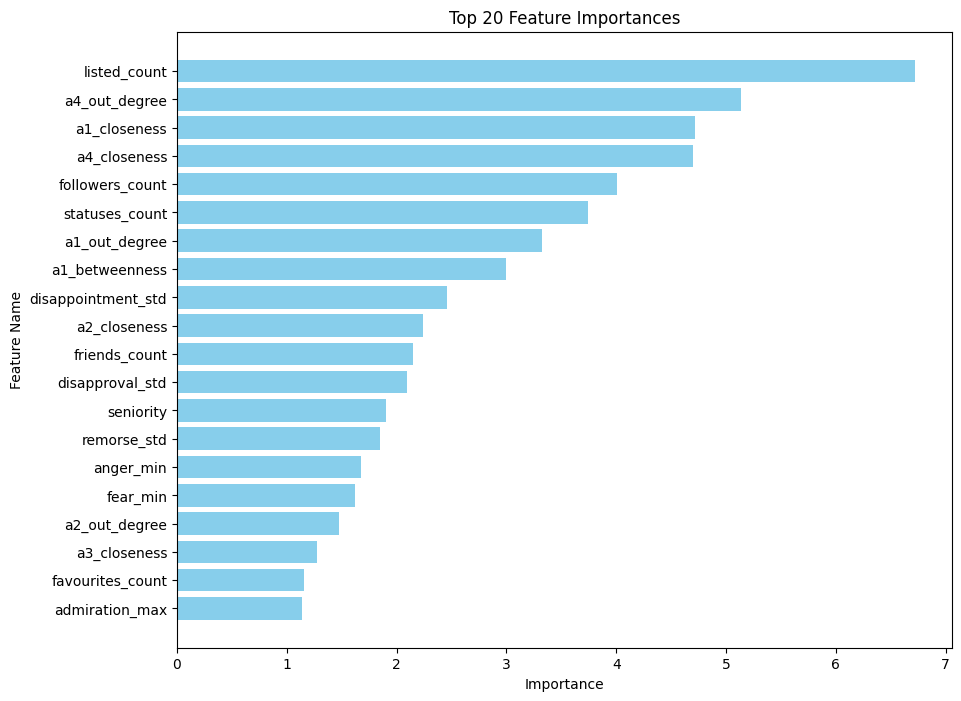

In [12]:
# Best model features importance plot
import matplotlib.pyplot as plt

# Load the best CatBoost model
model_cat_u_best_loaded = CatBoostClassifier()
model_cat_u_best_loaded.load_model("models/catboost_u3.cbm")

# Define feature names (ensure X_test has the columns defined)
feature_names = X_test_us_u.columns

# Retrieve and sort feature importance
feature_importance = model_cat_u_best_loaded.get_feature_importance()
feature_importance_map = dict(zip(feature_names, feature_importance))
sorted_importance = sorted(feature_importance_map.items(), key=lambda x: x[1], reverse=True)

# Select only the top 20 features
top_20_importance = sorted_importance[:20]
features, importances = zip(*top_20_importance)

# Create the bar chart for top 20 features
plt.figure(figsize=(10, 8))
plt.barh(features, importances, color='skyblue')  # Horizontal bar chart

# Add labels and title
plt.xlabel('Importance')
plt.ylabel('Feature Name')
plt.title('Top 20 Feature Importances')

# Invert y-axis to have the most important feature on top
plt.gca().invert_yaxis()

# Display the plot
plt.show()

In [5]:
import os
import optuna
import numpy as np
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import f1_score, accuracy_score, classification_report
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
import joblib

# Set the number of CPU cores to use
os.environ['LOKY_MAX_CPU_COUNT'] = '4'


# Define the objective function for Optuna
def objective(trial):
    # Suggest hyperparameters
    params = {
        "hidden_layer_sizes": (trial.suggest_int("num_units", 32, 256),) * trial.suggest_int("num_layers", 1, 4),
        "activation": trial.suggest_categorical("activation", ["relu", "tanh", "logistic"]),
        "solver": trial.suggest_categorical("solver", ["adam", "sgd"]),
        "alpha": trial.suggest_float("alpha", 1e-5, 1e-1, log=True),
        "learning_rate": trial.suggest_categorical("learning_rate", ["constant", "invscaling", "adaptive"]),
        "learning_rate_init": trial.suggest_float("learning_rate_init", 1e-4, 1e-1, log=True)
    }
    
    # Build and train the model
    model = make_pipeline(
        StandardScaler(),
        MLPClassifier(
            hidden_layer_sizes=params["hidden_layer_sizes"],
            activation=params["activation"],
            solver=params["solver"],
            alpha=params["alpha"],
            learning_rate=params["learning_rate"],
            learning_rate_init=params["learning_rate_init"],
            early_stopping=True,
            max_iter=300,
            random_state=42,
            verbose=0  # Set verbose to 0
        )
    )
    
    # Train the model
    model.fit(X_train_us_u, y_train_us_u)
    
    # Predict and evaluate
    y_pred = model.predict(X_test_u)
    f1_macro = f1_score(y_test_u, y_pred, average='macro')
    
    return f1_macro

# Define the number of trials
n_trials = 50

# Run the optimization with a progress bar
study = optuna.create_study(direction='maximize', sampler=optuna.samplers.TPESampler())
study.optimize(objective, n_trials=n_trials, show_progress_bar=True)

# Retrieve the best parameters
best_params = study.best_params
print(f"Best parameters found by Optuna: {best_params}")

# Train final model with the best parameters
model_nn_best = make_pipeline(
    StandardScaler(),
    MLPClassifier(
        hidden_layer_sizes=(best_params["num_units"],) * best_params["num_layers"],
        activation=best_params["activation"],
        solver=best_params["solver"],
        alpha=best_params["alpha"],
        learning_rate=best_params["learning_rate"],
        learning_rate_init=best_params["learning_rate_init"],
        early_stopping=True,  
        max_iter=300,
        random_state=42,
        verbose=0  # Set verbose to 0
    )
)
model_nn_best.fit(X_train_us_u, y_train_us_u)

# Predict and evaluate with the best model
y_pred_nn_best = model_nn_best.predict(X_test_u)

# Print metrics
print(f'Accuracy: {accuracy_score(y_test_u, y_pred_nn_best):.4f}')
print("Classification Report:")
print(classification_report(y_test_u, y_pred_nn_best, digits=4))

# Save the model
joblib.dump(model_nn_best, 'models/nn_u_new.joblib')
save_nn_evaluation_results('models/nn_u_new.joblib', X_test_u, y_test_u, X_test_us_u, y_test_us_u, 'models/nn_u_new.txt')


[I 2024-09-02 17:51:49,810] A new study created in memory with name: no-name-e73ef32e-ed07-409c-a381-5b96ee7645c0


  0%|          | 0/50 [00:00<?, ?it/s]

[I 2024-09-02 17:52:24,323] Trial 0 finished with value: 0.5442177595919582 and parameters: {'num_units': 247, 'num_layers': 1, 'activation': 'relu', 'solver': 'sgd', 'alpha': 0.000135309417876974, 'learning_rate': 'adaptive', 'learning_rate_init': 0.011580567244935058}. Best is trial 0 with value: 0.5442177595919582.
[I 2024-09-02 17:52:39,549] Trial 1 finished with value: 0.5569663055038474 and parameters: {'num_units': 90, 'num_layers': 1, 'activation': 'logistic', 'solver': 'adam', 'alpha': 0.0006880613978079296, 'learning_rate': 'adaptive', 'learning_rate_init': 0.0030831345001087512}. Best is trial 1 with value: 0.5569663055038474.
[I 2024-09-02 17:54:42,859] Trial 2 finished with value: 0.5271300452584851 and parameters: {'num_units': 67, 'num_layers': 4, 'activation': 'relu', 'solver': 'sgd', 'alpha': 0.032445362358496425, 'learning_rate': 'adaptive', 'learning_rate_init': 0.001361830572291469}. Best is trial 1 with value: 0.5569663055038474.
[I 2024-09-02 17:54:50,030] Trial 3

In [ ]:
# Best model features importance plot
import matplotlib.pyplot as plt

# Load the best CatBoost model
model_cat_u_best_loaded = CatBoostClassifier()
model_cat_u_best_loaded.load_model("models/catboost_u3.cbm")

# Define feature names (ensure X_test has the columns defined)
feature_names = X_test_us_u.columns

# Retrieve and sort feature importance
feature_importance = model_cat_u_best_loaded.get_feature_importance()
feature_importance_map = dict(zip(feature_names, feature_importance))
sorted_importance = sorted(feature_importance_map.items(), key=lambda x: x[1], reverse=True)

# Select only the top 20 features
top_20_importance = sorted_importance[:20]
features, importances = zip(*top_20_importance)

# Create the bar chart for top 20 features
plt.figure(figsize=(10, 8))
plt.barh(features, importances, color='skyblue')  # Horizontal bar chart

# Add labels and title
plt.xlabel('Importance')
plt.ylabel('Feature Name')
plt.title('Top 20 Feature Importances')

# Invert y-axis to have the most important feature on top
plt.gca().invert_yaxis()

# Display the plot
plt.show()